In [69]:
# !pip install torchdiffeq

In [70]:
# df_1 = pd.read_csv('C:\\Users\\praba\\Documents\\GitHub\\research-project-on-physics-informed-machine-learning-on-transcriptomics-data\\some extra papers\\examples.csv',sep=';')


In [71]:
# df_1

# Data preprocessing

In [72]:
# Data preprocessing
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# df = pd.read_csv('C:\\Users\\praba\\Documents\\GitHub\\research-project-on-physics-informed-machine-learning-on-transcriptomics-data\\arabido_example_genes.csv')
# df = pd.read_csv('C:\\Users\\praba\\Documents\\GitHub\\research-project-on-physics-informed-machine-learning-on-transcriptomics-data\\some extra papers\\examples.csv',sep=';')
df = pd.read_csv('arabido_example_genes.csv')

print(df)
df.info()  # Check data types
df.describe()  # Statistical summary

print(df.columns)
# print(df.columns.tolist())




  Unnamed: 0  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
0  AT5G40100  -0.447960  -0.560155  -5.091964
1  AT1G06930   1.778359   0.000000   0.000000
2  AT1G04470   0.000000   1.175150   0.000000
3  AT5G66730   0.055375   0.098435  -0.101757
4  AT2G38472   0.900000   0.500000   0.000000
5  AT2G38474   0.000000   0.500000   0.000000
6  AT2G38470   0.906000   0.906000   0.906000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  7 non-null      object 
 1   Hpa-NO_1d   7 non-null      float64
 2   Hpa-NO_2d   7 non-null      float64
 3   Hpa-NO_4d   7 non-null      float64
dtypes: float64(3), object(1)
memory usage: 356.0+ bytes
Index(['Unnamed: 0', 'Hpa-NO_1d', 'Hpa-NO_2d', 'Hpa-NO_4d'], dtype='object')


# 4. Neural ode +Inverse Pinn

## Parametric ODE Model for Each Gene: dy/dt = α + β * y(t) + γ * t


Original Data:
  Unnamed: 0  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
0  AT5G40100  -0.447960  -0.560155  -5.091964
1  AT1G06930   1.778359   0.000000   0.000000
2  AT1G04470   0.000000   1.175150   0.000000
3  AT5G66730   0.055375   0.098435  -0.101757
4  AT2G38472   0.900000   0.500000   0.000000
5  AT2G38474   0.000000   0.500000   0.000000
6  AT2G38470   0.906000   0.906000   0.906000
Epoch    0 | Total Loss: 3.1150 | Data Loss: 3.0890 | Physics Loss: 0.2601
Epoch  100 | Total Loss: 0.2029 | Data Loss: 0.1498 | Physics Loss: 0.5309
Epoch  200 | Total Loss: 0.1867 | Data Loss: 0.1343 | Physics Loss: 0.5244
Epoch  300 | Total Loss: 0.1780 | Data Loss: 0.1262 | Physics Loss: 0.5181
Epoch  400 | Total Loss: 0.1733 | Data Loss: 0.1218 | Physics Loss: 0.5148
Epoch  500 | Total Loss: 0.1707 | Data Loss: 0.1194 | Physics Loss: 0.5129
Epoch  600 | Total Loss: 0.1693 | Data Loss: 0.1181 | Physics Loss: 0.5119
Epoch  700 | Total Loss: 0.1686 | Data Loss: 0.1174 | Physics Loss: 0.5114
Epoch  800 | Tota

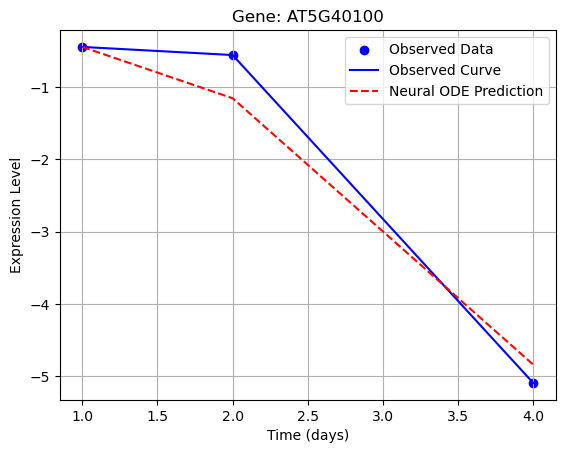

Learned ODE for Gene AT5G40100:
  dy/dt = -0.0029 + 0.3645 * y + -0.2869 * t
Formatted ODE Equation: dy/dt = -0.0029 + 0.3645 * y(t) + -0.2869 * t



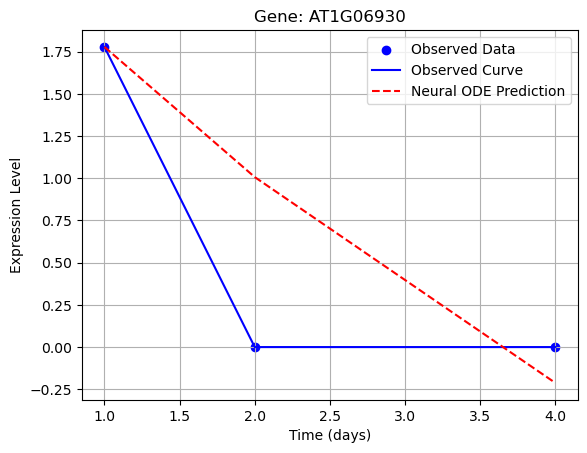

Learned ODE for Gene AT1G06930:
  dy/dt = -0.2061 + -0.3035 * y + -0.0973 * t
Formatted ODE Equation: dy/dt = -0.2061 + -0.3035 * y(t) + -0.0973 * t



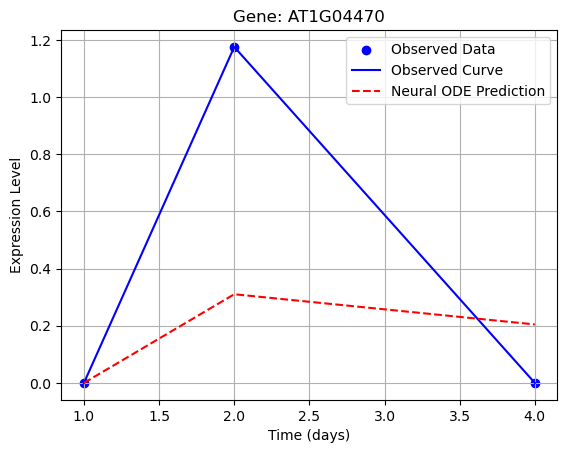

Learned ODE for Gene AT1G04470:
  dy/dt = 0.6920 + -0.4017 * y + -0.2056 * t
Formatted ODE Equation: dy/dt = 0.6920 + -0.4017 * y(t) + -0.2056 * t



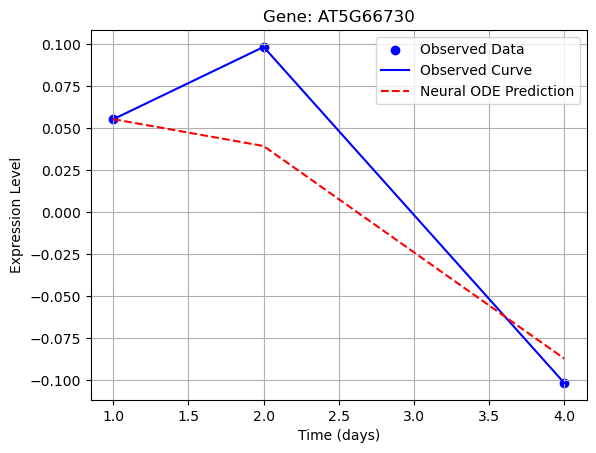

Learned ODE for Gene AT5G66730:
  dy/dt = 0.0370 + -0.0493 * y + -0.0337 * t
Formatted ODE Equation: dy/dt = 0.0370 + -0.0493 * y(t) + -0.0337 * t



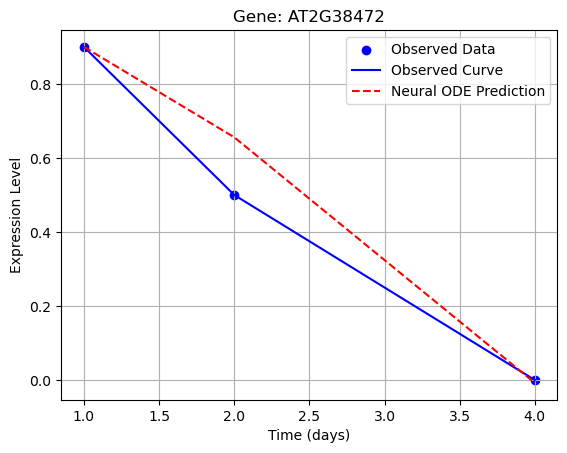

Learned ODE for Gene AT2G38472:
  dy/dt = -0.0478 + -0.0889 * y + -0.0845 * t
Formatted ODE Equation: dy/dt = -0.0478 + -0.0889 * y(t) + -0.0845 * t



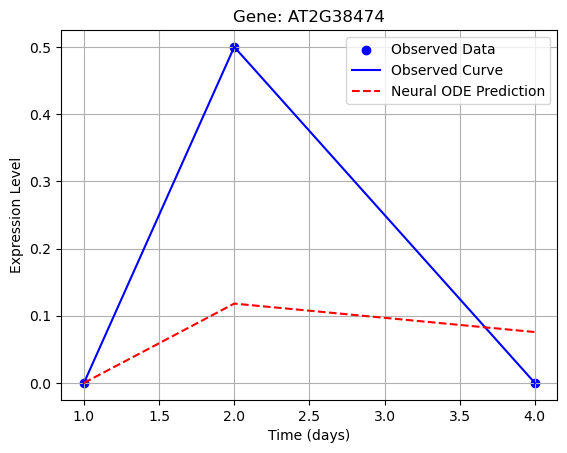

Learned ODE for Gene AT2G38474:
  dy/dt = 0.2588 + -0.1420 * y + -0.0874 * t
Formatted ODE Equation: dy/dt = 0.2588 + -0.1420 * y(t) + -0.0874 * t



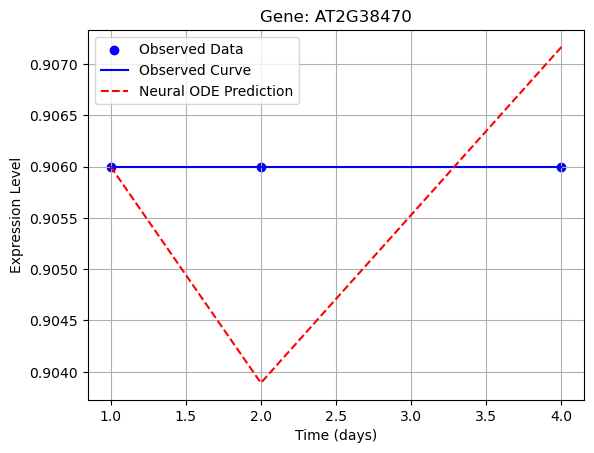

Learned ODE for Gene AT2G38470:
  dy/dt = 0.0086 + -0.0159 * y + 0.0025 * t
Formatted ODE Equation: dy/dt = 0.0086 + -0.0159 * y(t) + 0.0025 * t



In [75]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

##############################################################################
# Data Setup (Row-wise: Each row is a gene; columns are Day1, Day2, Day4)
##############################################################################

# Example dataset (here using gene names and expression values)
# data = {
#     "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730"],
#     "Hpa-NO_1d": [-0.44796, 1.77836, 0.0, 0.05537],
#     "Hpa-NO_2d": [-0.56015, 0.0, 1.17515, 0.09843],
#     "Hpa-NO_4d": [-5.09196, 0.0, 0.0, -0.10176],
# }


# data = {
#     "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730", "AT2G384713"],
#     "Hpa-NO_1d":  [-0.44796,    1.77836,     0.0,         0.05537,    0.505000   ],
#     "Hpa-NO_2d":  [-0.56015,    0.0,         1.17515,     0.09843,  0.505000   ],
#     "Hpa-NO_4d":  [-5.09196,    0.0,         0.0,        -0.10176,  0.505000   ],
# }


# df = pd.DataFrame(data)
df = df
print("Original Data:")
print(df)

# Time points (in days)
time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # Day1, Day2, Day4

# Extract gene expression data (each row is one gene)
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values

# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

##############################################################################
# Parametric ODE Model for Each Gene: dy/dt = α + β * y(t) + γ * t
##############################################################################

class GeneParametricODE(nn.Module):
    def __init__(self):
        super(GeneParametricODE, self).__init__()
        # Learnable parameters: α, β, and γ
        self.alpha = nn.Parameter(torch.tensor(0.1))
        self.beta = nn.Parameter(torch.tensor(0.1))
        self.gamma = nn.Parameter(torch.tensor(0.1))

    def forward(self, t, y):
        # ODE: dy/dt = α + β * y(t) + γ * t
        return self.alpha + self.beta * y + self.gamma * t

# Create one ODE model per gene
num_genes = gene_data_tensor.shape[0]
ode_models = nn.ModuleList([GeneParametricODE() for _ in range(num_genes)])

##############################################################################
# Inverse PINN Loss Function (Data Loss + Physics Loss)
##############################################################################

def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
    total_data_loss = 0.0
    total_physics_loss = 0.0
    n_genes = gene_data.shape[0]

    for i in range(n_genes):
        # Observed expression for gene i (shape: (num_time_points,))
        y_observed = gene_data[i]
        # Use the first time point as the initial condition
        y0 = y_observed[0].unsqueeze(0)  # shape: (1,)

        # Solve the ODE for gene i over the time points
        preds = odeint(ode_models[i], y0, time_points).squeeze()  # shape: (num_time_points,)

        # Data loss: Mean squared error between predictions and observed values
        data_loss = torch.mean((preds - y_observed)**2)

        # Physics loss: Enforce that the derivative from autograd matches the ODE output
        dy_dt_pred = torch.autograd.grad(
            outputs=preds,
            inputs=time_points,
            grad_outputs=torch.ones_like(preds),
            create_graph=True,
            retain_graph=True
        )[0]

        dy_dt_ode = []
        for t_val, p_val in zip(time_points, preds):
            deriv = ode_models[i](t_val, p_val.unsqueeze(0))
            dy_dt_ode.append(deriv.squeeze())
        dy_dt_ode = torch.stack(dy_dt_ode)

        physics_loss = torch.mean((dy_dt_pred - dy_dt_ode)**2)

        total_data_loss += data_loss
        total_physics_loss += physics_loss

    avg_data_loss = total_data_loss / n_genes
    avg_physics_loss = total_physics_loss / n_genes
    total_loss = avg_data_loss + lambda_physics * avg_physics_loss
    return total_loss, avg_data_loss, avg_physics_loss

##############################################################################
# Training Loop
##############################################################################

optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

epochs = 1400

for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, data_loss, physics_loss = inverse_pinn_loss(ode_models, time_points_tensor, gene_data_tensor, lambda_physics=0.1)
    total_loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Total Loss: {total_loss.item():.4f} | Data Loss: {data_loss.item():.4f} | Physics Loss: {physics_loss.item():.4f}")

##############################################################################
# Plotting Predictions and Printing Learned ODE Parameters
##############################################################################

with torch.no_grad():
    for i, gene_id in enumerate(df['Unnamed: 0']):
        # Use the Day1 value as the initial condition for each gene
        y0 = gene_data_tensor[i, 0].unsqueeze(0)  # shape: (1,)
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()

        # Plot observed data vs. Neural ODE predictions
        plt.figure()
        plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
        plt.plot(time_points, gene_data[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="Neural ODE Prediction")
        plt.title(f"Gene: {gene_id}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Print learned parameters for the gene
        model = ode_models[i]
        alpha = model.alpha.item()
        beta = model.beta.item()
        gamma = model.gamma.item()
        print(f"Learned ODE for Gene {gene_id}:")
        print(f"  dy/dt = {alpha:.4f} + {beta:.4f} * y + {gamma:.4f} * t")
        print(f"Formatted ODE Equation: dy/dt = {alpha:.4f} + {beta:.4f} * y(t) + {gamma:.4f} * t\n")



Learned Parameters:
        Gene     alpha      beta     gamma
0  AT5G40100 -0.002922  0.364459 -0.286876
1  AT1G06930 -0.206085 -0.303508 -0.097298
2  AT1G04470  0.691965 -0.401743 -0.205646
3  AT5G66730  0.036963 -0.049306 -0.033653
4  AT2G38472 -0.047785 -0.088944 -0.084508
5  AT2G38474  0.258802 -0.141963 -0.087414
6  AT2G38470  0.008567 -0.015940  0.002497


c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


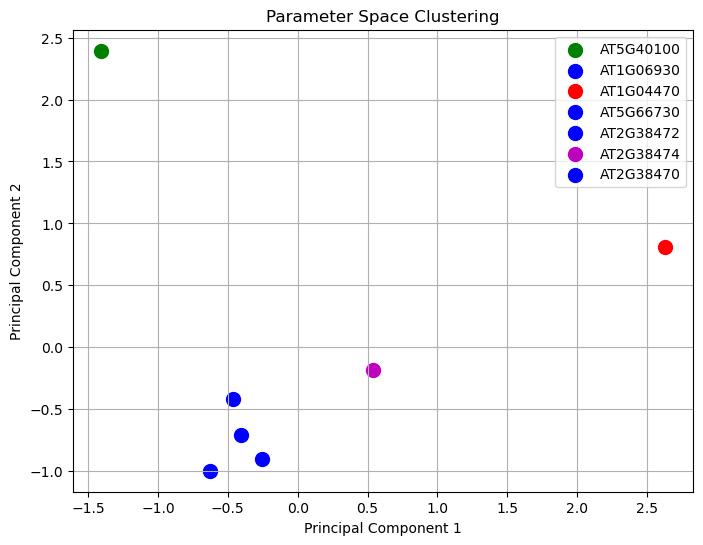


Cluster Analysis:

Cluster 0 - Genes:
AT1G04470
Parameter Statistics:
Alpha: μ = 0.6920 ± nan
Beta:  μ = -0.4017 ± nan
Gamma: μ = -0.2056 ± nan

Cluster 1 - Genes:
AT1G06930, AT5G66730, AT2G38472, AT2G38470
Parameter Statistics:
Alpha: μ = -0.0521 ± 0.1085
Beta:  μ = -0.1144 ± 0.1295
Gamma: μ = -0.0532 ± 0.0462

Cluster 2 - Genes:
AT5G40100
Parameter Statistics:
Alpha: μ = -0.0029 ± nan
Beta:  μ = 0.3645 ± nan
Gamma: μ = -0.2869 ± nan

Cluster 3 - Genes:
AT2G38474
Parameter Statistics:
Alpha: μ = 0.2588 ± nan
Beta:  μ = -0.1420 ± nan
Gamma: μ = -0.0874 ± nan

Parameters saved to gene_ode_parameters.csv


In [76]:
##############################################################################
# Step 1: Store and Print Learned Parameters
##############################################################################

# Create a DataFrame to store parameters
params_df = pd.DataFrame(columns=['Gene', 'alpha', 'beta', 'gamma'])

with torch.no_grad():
    for i, gene_id in enumerate(df['Unnamed: 0']):
        model = ode_models[i]
        params_df.loc[i] = [
            gene_id,
            model.alpha.item(),
            model.beta.item(),
            model.gamma.item()
        ]

print("\nLearned Parameters:")
print(params_df)

##############################################################################
# Step 2: Parameter Clustering using K-means
##############################################################################

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Prepare data for clustering
X = params_df[['alpha', 'beta', 'gamma']].values

# Normalize parameters
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add clusters to DataFrame
params_df['cluster'] = clusters

##############################################################################
# Step 3: Visualize Clusters with PCA
##############################################################################

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Create plot
plt.figure(figsize=(8, 6))
colors = ['r', 'b', 'g', 'm', 'y']
markers = ['o', 's', 'D', '^', 'v']

for i, gene in enumerate(params_df['Gene']):
    plt.scatter(
        principal_components[i, 0],
        principal_components[i, 1],
        c=colors[clusters[i]],
        # marker=markers[i],
        s=100,
        label=gene
    )

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Parameter Space Clustering')
plt.legend()
plt.grid(True)
plt.show()

##############################################################################
# Step 4: Cluster Analysis
##############################################################################

print("\nCluster Analysis:")
for cluster_id in sorted(params_df['cluster'].unique()):
    cluster_data = params_df[params_df['cluster'] == cluster_id]

    print(f"\nCluster {cluster_id} - Genes:")
    print(", ".join(cluster_data['Gene'].values))

    print("Parameter Statistics:")
    print(f"Alpha: μ = {cluster_data['alpha'].mean():.4f} ± {cluster_data['alpha'].std():.4f}")
    print(f"Beta:  μ = {cluster_data['beta'].mean():.4f} ± {cluster_data['beta'].std():.4f}")
    print(f"Gamma: μ = {cluster_data['gamma'].mean():.4f} ± {cluster_data['gamma'].std():.4f}")

##############################################################################
# Step 5: Save Parameters to CSV
##############################################################################

params_df.to_csv('gene_ode_parameters.csv', index=False)
print("\nParameters saved to gene_ode_parameters.csv")

c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


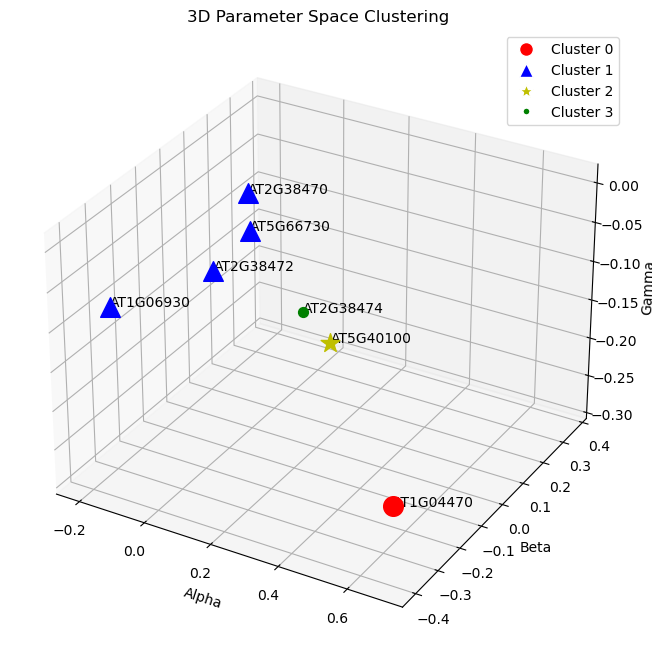

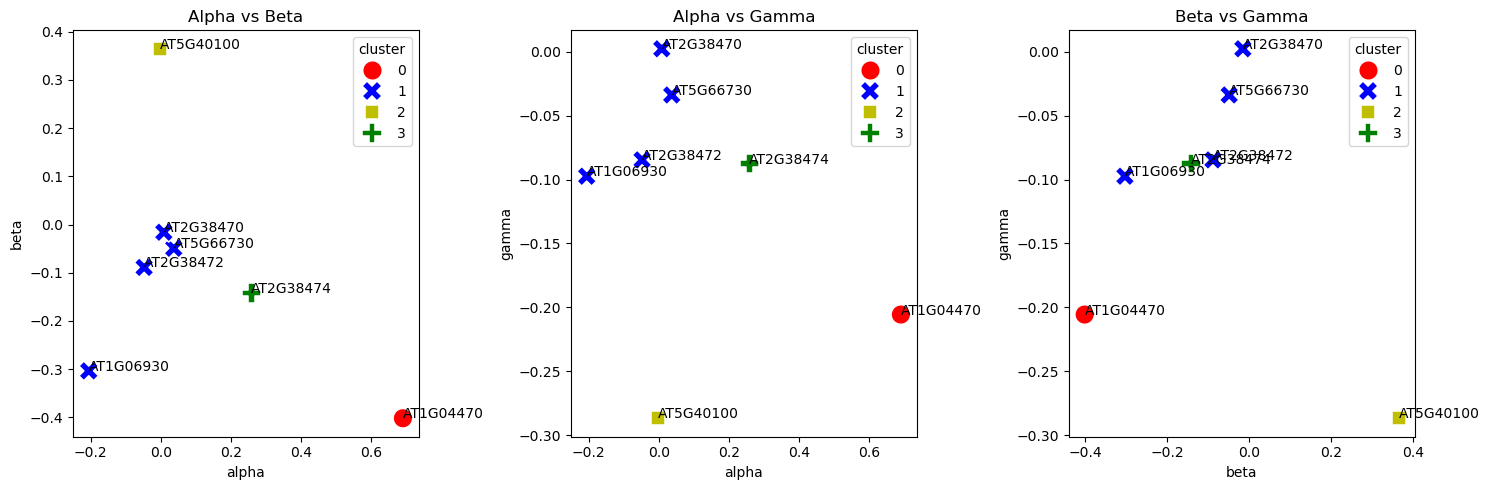


Cluster Characteristics:

Cluster 0 (1 genes):
Genes: AT1G04470
Alpha: μ = 0.6920 ± nan
Beta:  μ = -0.4017 ± nan
Gamma: μ = -0.2056 ± nan

Cluster 1 (4 genes):
Genes: AT1G06930, AT5G66730, AT2G38472, AT2G38470
Alpha: μ = -0.0521 ± 0.1085
Beta:  μ = -0.1144 ± 0.1295
Gamma: μ = -0.0532 ± 0.0462

Cluster 2 (1 genes):
Genes: AT5G40100
Alpha: μ = -0.0029 ± nan
Beta:  μ = 0.3645 ± nan
Gamma: μ = -0.2869 ± nan

Cluster 3 (1 genes):
Genes: AT2G38474
Alpha: μ = 0.2588 ± nan
Beta:  μ = -0.1420 ± nan
Gamma: μ = -0.0874 ± nan


In [77]:
##############################################################################
# Parameter Clustering and Visualization
##############################################################################

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Create a DataFrame with learned parameters
params = []
for i, gene_id in enumerate(df['Unnamed: 0']):
    model = ode_models[i]
    params.append({
        'Gene': gene_id,
        'alpha': model.alpha.item(),
        'beta': model.beta.item(),
        'gamma': model.gamma.item()
    })
params_df = pd.DataFrame(params)

# Normalize parameters for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(params_df[['alpha', 'beta', 'gamma']])

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
params_df['cluster'] = kmeans.fit_predict(X_scaled)

##############################################################################
# 3D Parameter Space Visualization
##############################################################################

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Assign colors and markers based on clusters
# colors = ['r', 'b']
# markers = ['o', '^']

colors = ['r', 'b', 'y', 'g']
markers = ['o', '^', '*', '.']
for idx, row in params_df.iterrows():
    ax.scatter(
        row['alpha'],
        row['beta'],
        row['gamma'],
        c=colors[row['cluster']],
        marker=markers[row['cluster']],
        s=200,
        label=row['Gene'] if idx == 0 else ""
    )

ax.set_xlabel('Alpha')
ax.set_ylabel('Beta')
ax.set_zlabel('Gamma')
ax.set_title('3D Parameter Space Clustering')

# Add gene labels
for idx, row in params_df.iterrows():
    ax.text(row['alpha'], row['beta'], row['gamma'], row['Gene'],
            size=10, zorder=1, color='k')

plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Cluster 0'),
    plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='b', markersize=10, label='Cluster 1'),
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='y', markersize=10, label='Cluster 2'),
    plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='g', markersize=10, label='Cluster 3')

])
plt.show()

##############################################################################
# Pairwise Parameter Visualization
##############################################################################

import seaborn as sns

# Create pair plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(data=params_df, x='alpha', y='beta', hue='cluster',
                style='cluster', s=200, palette=['r', 'b', 'y', 'g'])
plt.title('Alpha vs Beta')
for line in range(0, params_df.shape[0]):
    plt.text(params_df.alpha[line], params_df.beta[line], params_df.Gene[line])

plt.subplot(1, 3, 2)
sns.scatterplot(data=params_df, x='alpha', y='gamma', hue='cluster',
                style='cluster', s=200, palette=['r', 'b', 'y', 'g'])
plt.title('Alpha vs Gamma')
for line in range(0, params_df.shape[0]):
    plt.text(params_df.alpha[line], params_df.gamma[line], params_df.Gene[line])

plt.subplot(1, 3, 3)
sns.scatterplot(data=params_df, x='beta', y='gamma', hue='cluster',
                style='cluster', s=200, palette=['r', 'b', 'y', 'g'])
plt.title('Beta vs Gamma')
for line in range(0, params_df.shape[0]):
    plt.text(params_df.beta[line], params_df.gamma[line], params_df.Gene[line])

plt.tight_layout()
plt.show()

##############################################################################
# Cluster Analysis
##############################################################################

print("\nCluster Characteristics:")
for cluster in sorted(params_df.cluster.unique()):
    cluster_data = params_df[params_df.cluster == cluster]
    print(f"\nCluster {cluster} ({len(cluster_data)} genes):")
    print("Genes:", ", ".join(cluster_data.Gene.values))
    print(f"Alpha: μ = {cluster_data.alpha.mean():.4f} ± {cluster_data.alpha.std():.4f}")
    print(f"Beta:  μ = {cluster_data.beta.mean():.4f} ± {cluster_data.beta.std():.4f}")
    print(f"Gamma: μ = {cluster_data.gamma.mean():.4f} ± {cluster_data.gamma.std():.4f}")


Learned Parameters:
        Gene     alpha      beta     gamma
0  AT5G40100 -0.002922  0.364459 -0.286876
1  AT1G06930 -0.206085 -0.303508 -0.097298
2  AT1G04470  0.691965 -0.401743 -0.205646
3  AT5G66730  0.036963 -0.049306 -0.033653
4  AT2G38472 -0.047785 -0.088944 -0.084508
5  AT2G38474  0.258802 -0.141963 -0.087414
6  AT2G38470  0.008567 -0.015940  0.002497


c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


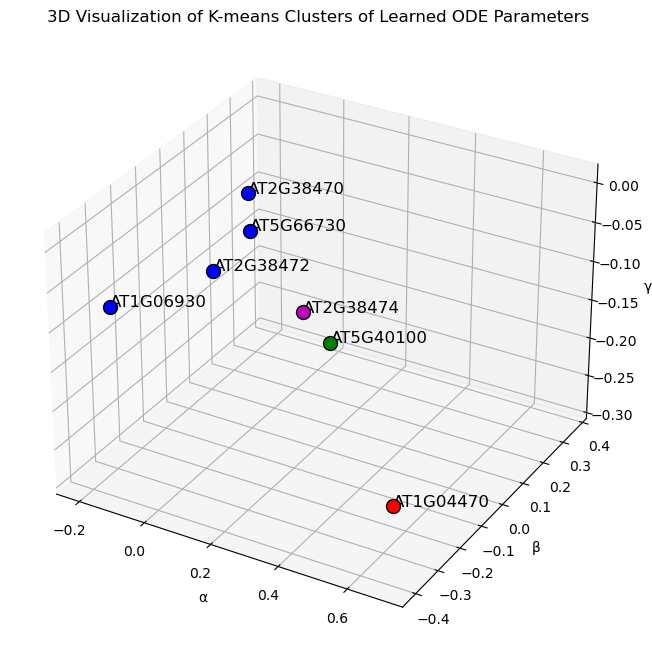


Cluster Analysis:

Cluster 0 - Genes:
AT1G04470
Parameter Statistics:
Alpha: μ = 0.6920 ± nan
Beta:  μ = -0.4017 ± nan
Gamma: μ = -0.2056 ± nan

Cluster 1 - Genes:
AT1G06930, AT5G66730, AT2G38472, AT2G38470
Parameter Statistics:
Alpha: μ = -0.0521 ± 0.1085
Beta:  μ = -0.1144 ± 0.1295
Gamma: μ = -0.0532 ± 0.0462

Cluster 2 - Genes:
AT5G40100
Parameter Statistics:
Alpha: μ = -0.0029 ± nan
Beta:  μ = 0.3645 ± nan
Gamma: μ = -0.2869 ± nan

Cluster 3 - Genes:
AT2G38474
Parameter Statistics:
Alpha: μ = 0.2588 ± nan
Beta:  μ = -0.1420 ± nan
Gamma: μ = -0.0874 ± nan

Parameters saved to gene_ode_parameters.csv


In [78]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

##############################################################################
# Step 1: Store and Print Learned Parameters
##############################################################################

# Assume ode_models is already trained and available from previous steps.
# Create a DataFrame to store parameters
params_df = pd.DataFrame(columns=['Gene', 'alpha', 'beta', 'gamma'])

with torch.no_grad():
    for i, gene_id in enumerate(df['Unnamed: 0']):
        model = ode_models[i]
        params_df.loc[i] = [
            gene_id,
            model.alpha.item(),
            model.beta.item(),
            model.gamma.item()
        ]

print("\nLearned Parameters:")
print(params_df)

##############################################################################
# Step 2: Parameter Clustering using K-means
##############################################################################

from sklearn.preprocessing import StandardScaler

# Prepare data for clustering
X = params_df[['alpha', 'beta', 'gamma']].values

# Normalize parameters
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add clusters to DataFrame
params_df['cluster'] = clusters

##############################################################################
# Step 3: Visualize Clusters in 3D (without PCA)
##############################################################################

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors to use for clusters
colors = ['r', 'b', 'g', 'm', 'y']

for idx, row in params_df.iterrows():
    ax.scatter(row['alpha'], row['beta'], row['gamma'],
               color=colors[row['cluster'] % len(colors)],
               s=100, edgecolor='k')
    ax.text(row['alpha'], row['beta'], row['gamma'], row['Gene'],
            size=12, zorder=1, color='k')

ax.set_xlabel('α')
ax.set_ylabel('β')
ax.set_zlabel('γ')
ax.set_title('3D Visualization of K-means Clusters of Learned ODE Parameters')
plt.show()

##############################################################################
# Step 4: Cluster Analysis
##############################################################################

print("\nCluster Analysis:")
for cluster_id in sorted(params_df['cluster'].unique()):
    cluster_data = params_df[params_df['cluster'] == cluster_id]

    print(f"\nCluster {cluster_id} - Genes:")
    print(", ".join(cluster_data['Gene'].values))

    print("Parameter Statistics:")
    print(f"Alpha: μ = {cluster_data['alpha'].mean():.4f} ± {cluster_data['alpha'].std():.4f}")
    print(f"Beta:  μ = {cluster_data['beta'].mean():.4f} ± {cluster_data['beta'].std():.4f}")
    print(f"Gamma: μ = {cluster_data['gamma'].mean():.4f} ± {cluster_data['gamma'].std():.4f}")

##############################################################################
# Step 5: Save Parameters to CSV
##############################################################################

params_df.to_csv('gene_ode_parameters.csv', index=False)
print("\nParameters saved to gene_ode_parameters.csv")


In [83]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# Generate synthetic test data
test_data = {
    "Unnamed: 0": ["AT5G40101", "AT1G06930", "AT1G04470", "AT5G66730", "AT2G38471"],
    "Hpa-NO_1d": [-0.5, 1.8, 0.1, 0.05, 0.5],
    "Hpa-NO_2d": [-0.6, 0.1, 1.2, 0.1, 0.8],
    "Hpa-NO_4d": [-5.1, 0.1, 0.1, -0.1, 0.5],
}

test_df = pd.DataFrame(test_data)
print("Test Data:")
print(test_df)


Test Data:
  Unnamed: 0  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
0  AT5G40101      -0.50       -0.6       -5.1
1  AT1G06930       1.80        0.1        0.1
2  AT1G04470       0.10        1.2        0.1
3  AT5G66730       0.05        0.1       -0.1
4  AT2G38471       0.50        0.8        0.5


In [84]:

# Extract gene expression data from test data
test_gene_data = test_df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values
print(test_gene_data)
# Convert to PyTorch tensors
test_gene_data_tensor = torch.tensor(test_gene_data, dtype=torch.float32)


[[-0.5  -0.6  -5.1 ]
 [ 1.8   0.1   0.1 ]
 [ 0.1   1.2   0.1 ]
 [ 0.05  0.1  -0.1 ]
 [ 0.5   0.8   0.5 ]]


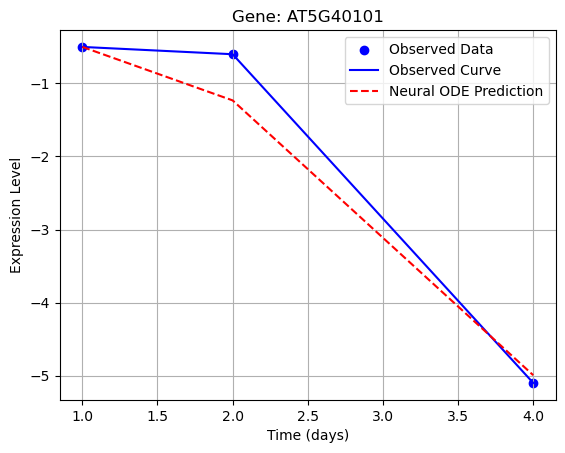

Learned ODE for Gene AT5G40101:
  dy/dt = -0.0029 + 0.3645 * y + -0.2869 * t
Formatted ODE Equation: dy/dt = -0.0029 + 0.3645 * y(t) + -0.2869 * t



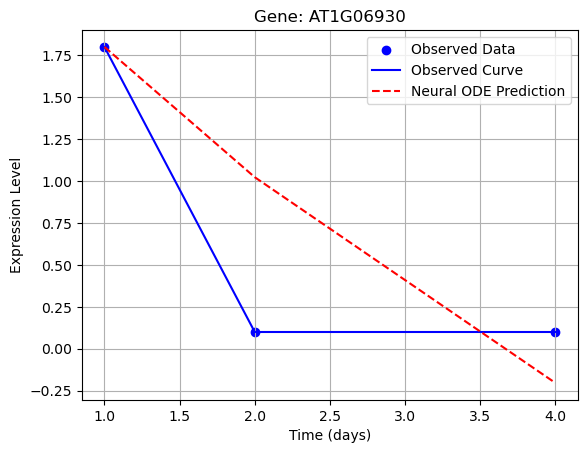

Learned ODE for Gene AT1G06930:
  dy/dt = -0.2061 + -0.3035 * y + -0.0973 * t
Formatted ODE Equation: dy/dt = -0.2061 + -0.3035 * y(t) + -0.0973 * t



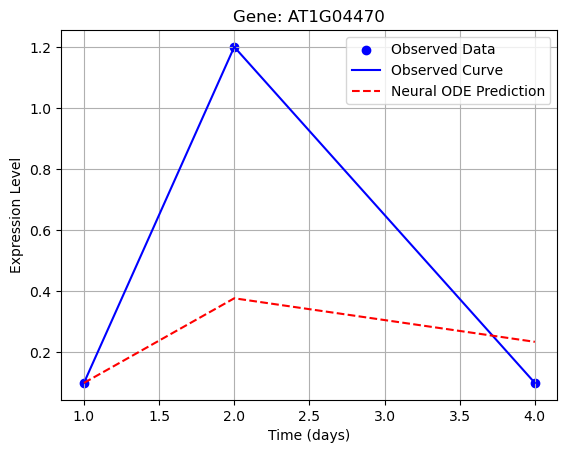

Learned ODE for Gene AT1G04470:
  dy/dt = 0.6920 + -0.4017 * y + -0.2056 * t
Formatted ODE Equation: dy/dt = 0.6920 + -0.4017 * y(t) + -0.2056 * t



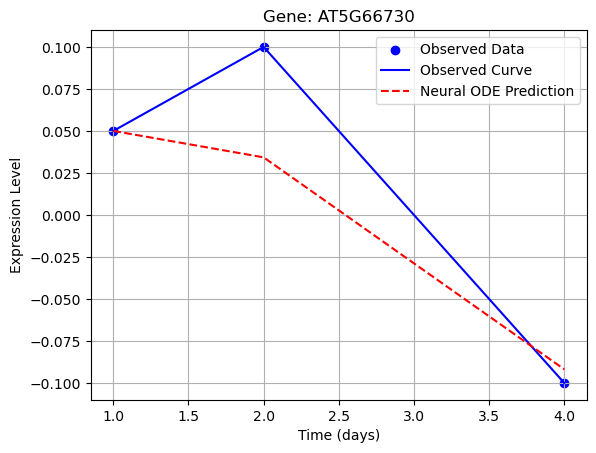

Learned ODE for Gene AT5G66730:
  dy/dt = 0.0370 + -0.0493 * y + -0.0337 * t
Formatted ODE Equation: dy/dt = 0.0370 + -0.0493 * y(t) + -0.0337 * t



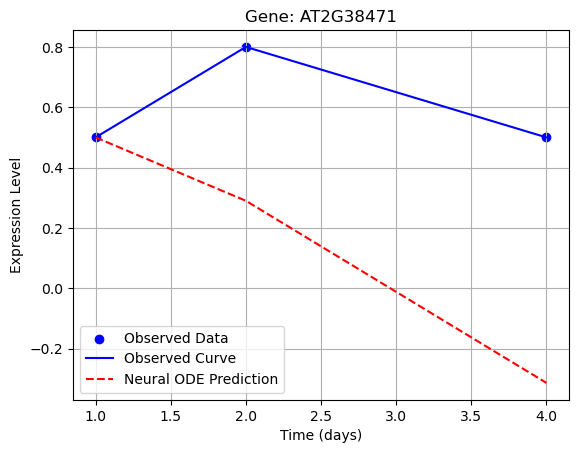

Learned ODE for Gene AT2G38471:
  dy/dt = -0.0478 + -0.0889 * y + -0.0845 * t
Formatted ODE Equation: dy/dt = -0.0478 + -0.0889 * y(t) + -0.0845 * t



In [85]:

# Use the trained model to make predictions on the test data
with torch.no_grad():
    for i, gene_id in enumerate(test_df['Unnamed: 0']):
        # Use the Day1 value as the initial condition for each gene
        y0 = test_gene_data_tensor[i, 0].unsqueeze(0)  # shape: (1,)
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()

        # Plot observed data vs. Neural ODE predictions
        plt.figure()
        plt.scatter(time_points, test_gene_data[i], c='b', label="Observed Data")
        plt.plot(time_points, test_gene_data[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="Neural ODE Prediction")
        plt.title(f"Gene: {gene_id}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Print learned parameters for the gene
        model = ode_models[i]
        alpha = model.alpha.item()
        beta = model.beta.item()
        gamma = model.gamma.item()
        print(f"Learned ODE for Gene {gene_id}:")
        print(f"  dy/dt = {alpha:.4f} + {beta:.4f} * y + {gamma:.4f} * t")
        print(f"Formatted ODE Equation: dy/dt = {alpha:.4f} + {beta:.4f} * y(t) + {gamma:.4f} * t\n")

In [57]:


# ##############################################################################
# # Step 1: Generate Synthetic Test Data
# ##############################################################################

# def generate_test_data(original_data, noise_level=0.1):
#     """
#     Generate test data by adding Gaussian noise to original data
#     """
#     test_data = {}
#     for gene, values in original_data.items():
#         noisy_values = [v + np.random.normal(0, noise_level) for v in values]
#         test_data[gene] = noisy_values
#     return test_data

# # Generate test data
# test_data = generate_test_data({
#     "AT5G40100": [-0.4, -0.55, -5.0],
#     "AT1G06930": [1.7, 0.1, -0.05],
#     "AT1G04470": [0.05, 1.1, 0.1],
#     "AT5G66730": [0.06, 0.09, -0.1],
#     "AT2G38471": [0.5, 0.5, 0.5]
# })

# # Convert to tensor
# test_data_tensor = torch.tensor([test_data[gene] for gene in df['Unnamed: 0']], dtype=torch.float32)

# ##############################################################################
# # Step 2: Test Model on New Data
# ##############################################################################

# def test_model(ode_models, time_points, test_data):
#     predictions = []
#     with torch.no_grad():
#         for i, gene in enumerate(df['Unnamed: 0']):
#             y0 = test_data[i, 0].unsqueeze(0)
#             preds = odeint(ode_models[i], y0, time_points).squeeze().numpy()
#             predictions.append(preds)
#     return np.array(predictions)

# # Get predictions
# test_predictions = test_model(ode_models, time_points_tensor, test_data_tensor)

# ##############################################################################
# # Step 3: Plot Test Predictions
# ##############################################################################

# plt.figure(figsize=(10, 6))
# for i, gene_id in enumerate(df['Unnamed: 0']):
#     plt.subplot(3, 2, i+1)
#     plt.scatter(time_points, gene_data[i], c='b', label='Train Data')
#     plt.scatter(time_points, test_data_tensor[i], c='r', marker='x', label='Test Data')
#     plt.plot(time_points, test_predictions[i], 'g--', label='Prediction')
#     plt.title(gene_id)
#     plt.xlabel('Days')
#     plt.ylabel('Expression')
#     plt.legend()
# plt.tight_layout()
# plt.show()

In [58]:
# ##############################################################################
# # Step 1: Generate Synthetic Test Data
# ##############################################################################

# def generate_test_data(original_data, noise_level=0.1):
#     """
#     Generate test data by adding Gaussian noise to original data
#     """
#     test_data = {}
#     for gene, values in original_data.items():
#         noisy_values = [v + np.random.normal(0, noise_level) for v in values]
#         test_data[gene] = noisy_values
#     return test_data

# # Generate test data
# test_data = {
#     "AT5G40100": [-0.4, -0.55, -5.0],
#     "AT1G06930": [1.7, 0.1, -0.05],
#     "AT1G04470": [0.05, 1.1, 0.1],
#     "AT5G66730": [0.06, 0.09, -0.1],
#     "AT2G384713": [0.5, 0.5, 0.5]
# }

# # Convert to tensor
# test_data_tensor = torch.tensor([test_data[gene] for gene in df['Unnamed: 0']], dtype=torch.float32)

# ##############################################################################
# # Step 2: Test Model on New Data
# ##############################################################################

# def test_model(ode_models, time_points, test_data):
#     predictions = []
#     with torch.no_grad():
#         for i, gene in enumerate(df['Gene']):
#             y0 = test_data[i, 0].unsqueeze(0)
#             preds = odeint(ode_models[i], y0, time_points).squeeze().numpy()
#             predictions.append(preds)
#     return np.array(predictions)

# # Get predictions
# test_predictions = test_model(ode_models, time_points_tensor, test_data_tensor)

# ##############################################################################
# # Step 3: Plot Test Predictions
# ##############################################################################

# plt.figure(figsize=(10, 6))
# for i, gene_id in enumerate(df['Gene']):
#     plt.subplot(3, 2, i+1)
#     plt.scatter(time_points, gene_data[i], c='b', label='Train Data')
#     plt.scatter(time_points, test_data_tensor[i], c='r', marker='x', label='Test Data')
#     plt.plot(time_points, test_predictions[i], 'g--', label='Prediction')
#     plt.title(gene_id)
#     plt.xlabel('Days')
#     plt.ylabel('Expression')
#     plt.legend()
# plt.tight_layout()
# plt.show()


In [87]:

##############################################################################
# Step 4: Parameter Clustering
##############################################################################

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Collect parameters
params = []
for model in ode_models:
    params.append([
        model.alpha.item(),
        model.beta.item(),
        model.gamma.item()
    ])
params = np.array(params)

# Normalize parameters
scaler = StandardScaler()
scaled_params = scaler.fit_transform(params)

# Cluster using K-means
kmeans = KMeans(n_clusters=2, random_state=0).fit(scaled_params)
cluster_labels = kmeans.labels_

# PCA for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_params)



c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


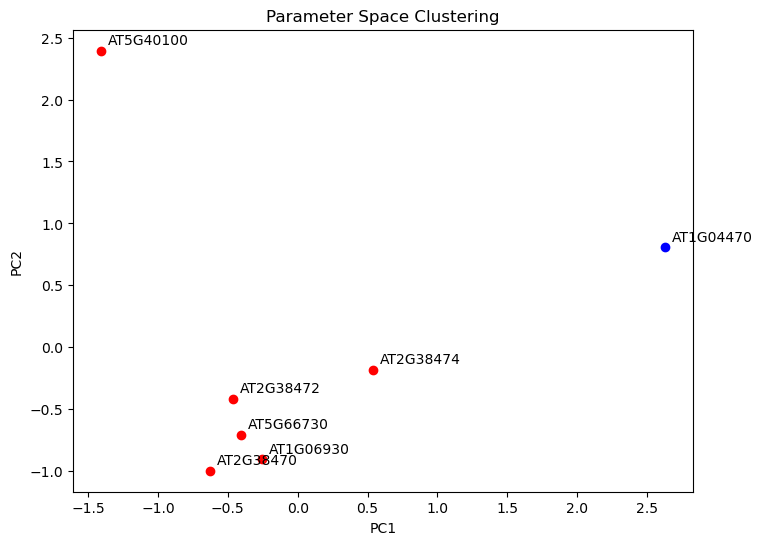


Cluster Analysis:

Cluster 0 Genes:
AT5G40100, AT1G06930, AT5G66730, AT2G38472, AT2G38474, AT2G38470
Average Parameters:
α: 0.0079 ± 0.1371
β: -0.0392 ± 0.2027
γ: -0.0979 ± 0.0915

Cluster 1 Genes:
AT1G04470
Average Parameters:
α: 0.6920 ± 0.0000
β: -0.4017 ± 0.0000
γ: -0.2056 ± 0.0000


In [88]:
# Plot clusters
plt.figure(figsize=(8, 6))
for i, gene in enumerate(df['Unnamed: 0']):
    plt.scatter(principal_components[i, 0], principal_components[i, 1],
                c=['r', 'b'][cluster_labels[i]], label=gene)
    plt.text(principal_components[i, 0]+0.05, principal_components[i, 1]+0.05, gene)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Parameter Space Clustering')
plt.show()

##############################################################################
# Step 5: Print Cluster Analysis
##############################################################################

print("\nCluster Analysis:")
for cluster_id in np.unique(cluster_labels):
    cluster_genes = df['Unnamed: 0'][cluster_labels == cluster_id]
    print(f"\nCluster {cluster_id} Genes:")
    print(", ".join(cluster_genes))

    cluster_params = params[cluster_labels == cluster_id]
    print(f"Average Parameters:")
    print(f"α: {cluster_params[:, 0].mean():.4f} ± {cluster_params[:, 0].std():.4f}")
    print(f"β: {cluster_params[:, 1].mean():.4f} ± {cluster_params[:, 1].std():.4f}")
    print(f"γ: {cluster_params[:, 2].mean():.4f} ± {cluster_params[:, 2].std():.4f}")

In [93]:
# Store learned parameters in a DataFrame
params = []
for i, gene_id in enumerate(df['Unnamed: 0']):
    model = ode_models[i]
    params.append({
        'Unnamed: 0': gene_id,
        'alpha': model.alpha.item(),
        'beta': model.beta.item(),
        'gamma': model.gamma.item()
    })
params_df = pd.DataFrame(params)

print("\nLearned Parameters:")
print(params_df)


Learned Parameters:
  Unnamed: 0     alpha      beta     gamma
0  AT5G40100 -0.002922  0.364459 -0.286876
1  AT1G06930 -0.206085 -0.303508 -0.097298
2  AT1G04470  0.691965 -0.401743 -0.205646
3  AT5G66730  0.036963 -0.049306 -0.033653
4  AT2G38472 -0.047785 -0.088944 -0.084508
5  AT2G38474  0.258802 -0.141963 -0.087414
6  AT2G38470  0.008567 -0.015940  0.002497


In [94]:
from sklearn.cluster import KMeans

# Number of clusters for each parameter
n_clusters = 3

# Cluster alpha values
kmeans_alpha = KMeans(n_clusters=n_clusters, random_state=42)
params_df['alpha_cluster'] = kmeans_alpha.fit_predict(params_df[['alpha']])

# Cluster beta values
kmeans_beta = KMeans(n_clusters=n_clusters, random_state=42)
params_df['beta_cluster'] = kmeans_beta.fit_predict(params_df[['beta']])

# Cluster gamma values
kmeans_gamma = KMeans(n_clusters=n_clusters, random_state=42)
params_df['gamma_cluster'] = kmeans_gamma.fit_predict(params_df[['gamma']])

print("\nClustered Parameters:")
print(params_df)


Clustered Parameters:
  Unnamed: 0     alpha      beta     gamma  alpha_cluster  beta_cluster  \
0  AT5G40100 -0.002922  0.364459 -0.286876              1             2   
1  AT1G06930 -0.206085 -0.303508 -0.097298              2             0   
2  AT1G04470  0.691965 -0.401743 -0.205646              0             0   
3  AT5G66730  0.036963 -0.049306 -0.033653              1             1   
4  AT2G38472 -0.047785 -0.088944 -0.084508              1             1   
5  AT2G38474  0.258802 -0.141963 -0.087414              1             1   
6  AT2G38470  0.008567 -0.015940  0.002497              1             1   

   gamma_cluster  
0              2  
1              1  
2              0  
3              1  
4              1  
5              1  
6              1  


c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


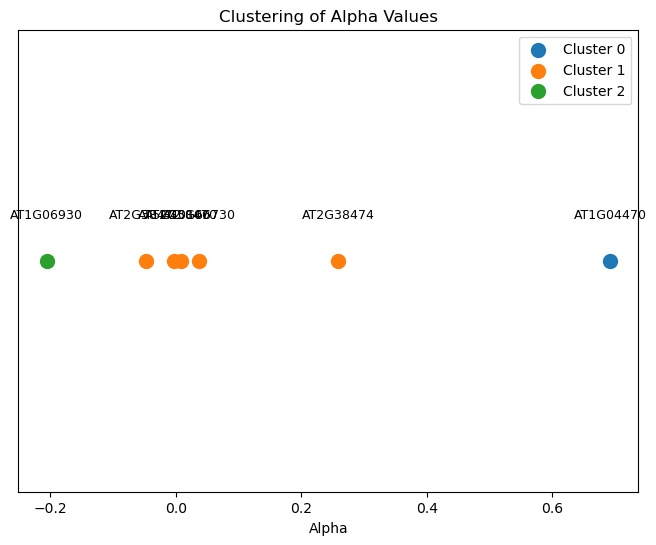

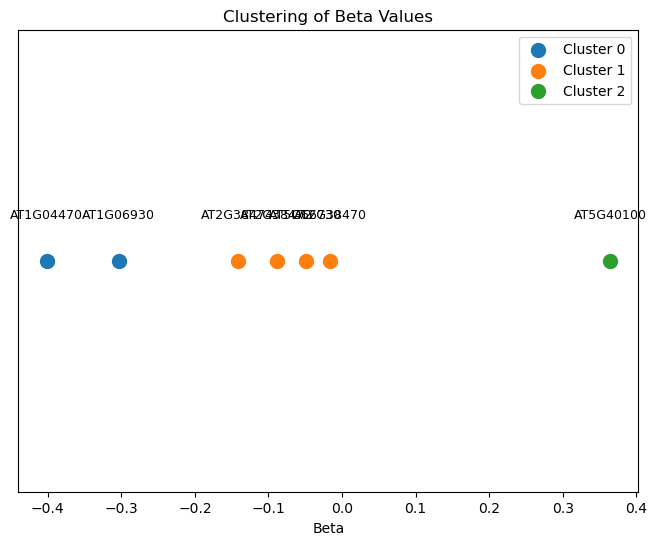

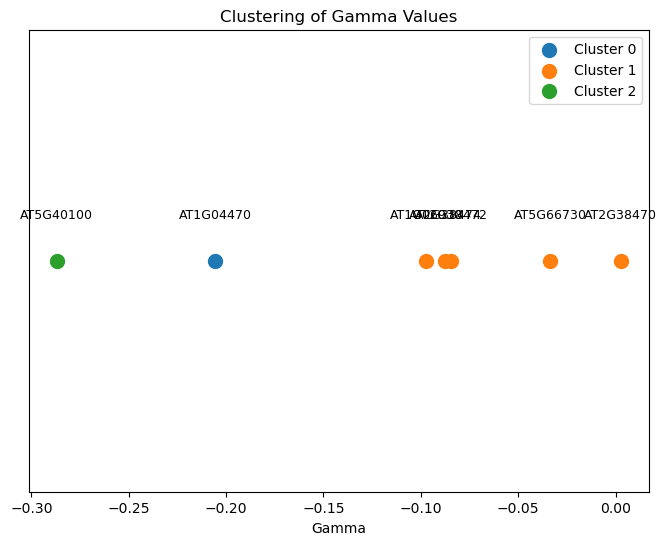

In [95]:
# Plot clusters for alpha
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    cluster_data = params_df[params_df['alpha_cluster'] == cluster]
    plt.scatter(cluster_data['alpha'], np.zeros_like(cluster_data['alpha']),
                label=f'Cluster {cluster}', s=100)
    for _, row in cluster_data.iterrows():
        plt.text(row['alpha'], 0.01, row['Unnamed: 0'], fontsize=9, ha='center')
plt.title('Clustering of Alpha Values')
plt.xlabel('Alpha')
plt.yticks([])
plt.legend()
plt.show()

# Plot clusters for beta
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    cluster_data = params_df[params_df['beta_cluster'] == cluster]
    plt.scatter(cluster_data['beta'], np.zeros_like(cluster_data['beta']),
                label=f'Cluster {cluster}', s=100)
    for _, row in cluster_data.iterrows():
        plt.text(row['beta'], 0.01, row['Unnamed: 0'], fontsize=9, ha='center')
plt.title('Clustering of Beta Values')
plt.xlabel('Beta')
plt.yticks([])
plt.legend()
plt.show()

# Plot clusters for gamma
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    cluster_data = params_df[params_df['gamma_cluster'] == cluster]
    plt.scatter(cluster_data['gamma'], np.zeros_like(cluster_data['gamma']),
                label=f'Cluster {cluster}', s=100)
    for _, row in cluster_data.iterrows():
        plt.text(row['gamma'], 0.01, row['Unnamed: 0'], fontsize=9, ha='center')
plt.title('Clustering of Gamma Values')
plt.xlabel('Gamma')
plt.yticks([])
plt.legend()
plt.show()

In [101]:
print("\nCluster Analysis:")

# Alpha clusters
print("\nAlpha Clusters:")
for cluster in range(n_clusters):
    cluster_genes = params_df[params_df['alpha_cluster'] == cluster]['Unnamed: 0'].values
    
    print(f"Cluster {cluster}: {', '.join(cluster_genes)}")

# Beta clusters
print("\nBeta Clusters:")
for cluster in range(n_clusters):
    cluster_genes = params_df[params_df['beta_cluster'] == cluster]['Unnamed: 0'].values
    print(f"Cluster {cluster}: {', '.join(cluster_genes)}")

# Gamma clusters
print("\nGamma Clusters:")
for cluster in range(n_clusters):
    cluster_genes = params_df[params_df['gamma_cluster'] == cluster]['Unnamed: 0'].values
    print(f"Cluster {cluster}: {', '.join(cluster_genes)}")


Cluster Analysis:

Alpha Clusters:
Cluster 0: AT1G04470
Cluster 1: AT5G40100, AT5G66730, AT2G38472, AT2G38474, AT2G38470
Cluster 2: AT1G06930

Beta Clusters:
Cluster 0: AT1G06930, AT1G04470
Cluster 1: AT5G66730, AT2G38472, AT2G38474, AT2G38470
Cluster 2: AT5G40100

Gamma Clusters:
Cluster 0: AT1G04470
Cluster 1: AT1G06930, AT5G66730, AT2G38472, AT2G38474, AT2G38470
Cluster 2: AT5G40100


In [97]:
params_df.to_csv('clustered_parameters.csv', index=False)
print("\nClustered parameters saved to 'clustered_parameters.csv'.")


Clustered parameters saved to 'clustered_parameters.csv'.


------------------


Synthetic Test Data:
[[-0.76616239 -0.74975054 -1.83391877]
 [-0.83935845 -0.89596382 -2.47785093]
 [ 0.6477127   2.72858692 20.67418107]
 [-0.57946823 -1.71870585 -6.95081168]
 [ 0.73334083  0.24598725 -3.33682259]]
True underlying parameters (α, β, γ) for test genes:
[[-0.92203179 -0.36010589  0.0432188 ]
 [ 0.26061342 -0.21389099 -0.49169875]
 [ 0.36854739  0.77542493  0.38748648]
 [-0.70591941  0.48319891  0.07783666]
 [-0.47586349  0.51404961 -0.22031214]]


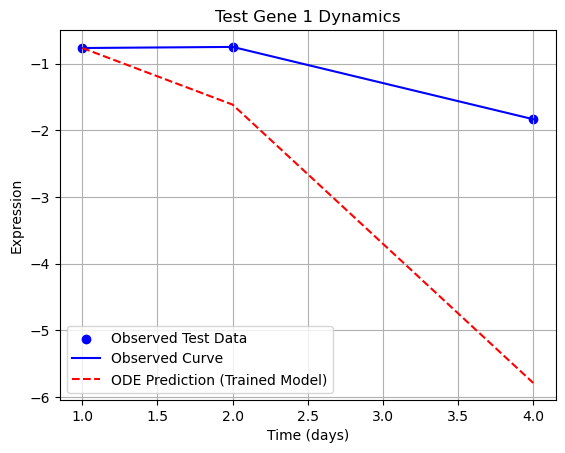

Learned ODE for Test Gene 1 (using Trained Model 1):
  dy/dt = -0.0029 + 0.3645 * y(t) + -0.2869 * t



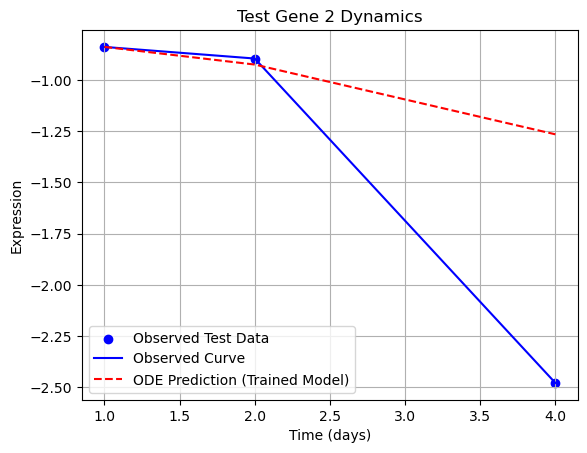

Learned ODE for Test Gene 2 (using Trained Model 2):
  dy/dt = -0.2061 + -0.3035 * y(t) + -0.0973 * t



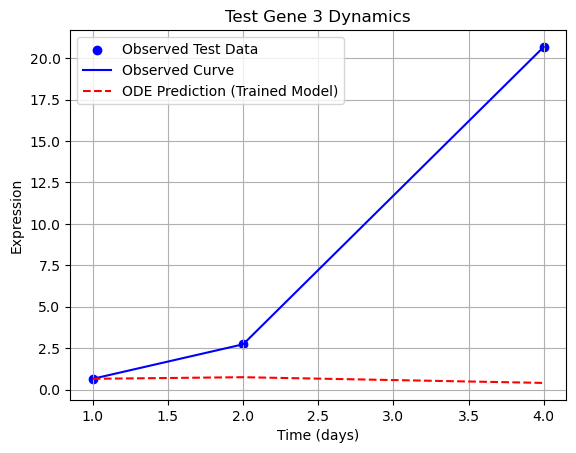

Learned ODE for Test Gene 3 (using Trained Model 3):
  dy/dt = 0.6920 + -0.4017 * y(t) + -0.2056 * t



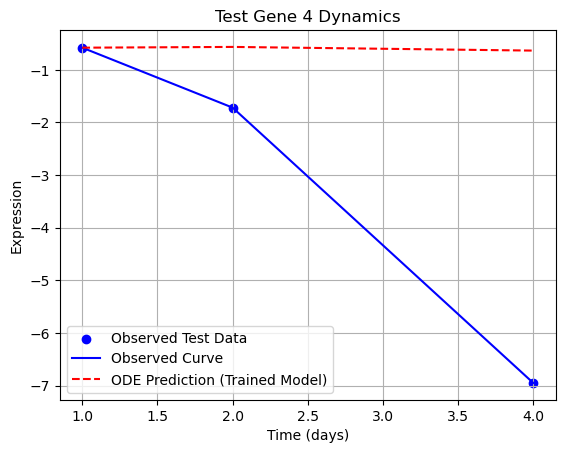

Learned ODE for Test Gene 4 (using Trained Model 4):
  dy/dt = 0.0370 + -0.0493 * y(t) + -0.0337 * t



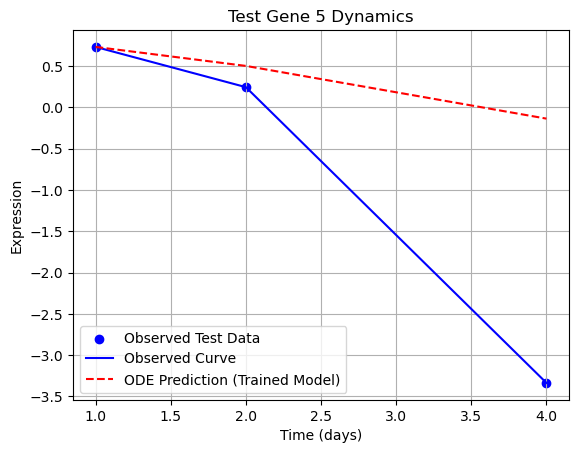

Learned ODE for Test Gene 5 (using Trained Model 5):
  dy/dt = -0.0478 + -0.0889 * y(t) + -0.0845 * t

Cluster assignments for trained ODE parameters (used for testing):
[1 1 0 1 1]


c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


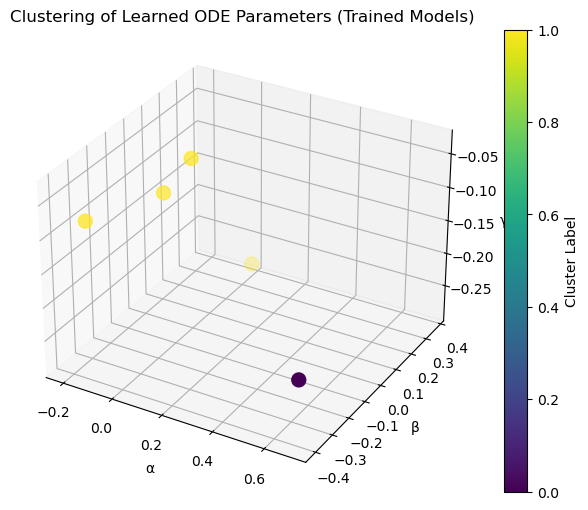

In [102]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from scipy.integrate import odeint as scipy_odeint

# ##############################################################################
# # 1. Data Setup (Training Data)
# ##############################################################################

# data = {
#     "Gene": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730", "AT2G384713"],
#     "Hpa-NO_1d":  [-0.44796,    1.77836,     0.0,         0.05537,    0.505000],
#     "Hpa-NO_2d":  [-0.56015,    0.0,         1.17515,     0.09843,    0.505000],
#     "Hpa-NO_4d":  [-5.09196,    0.0,         0.0,        -0.10176,    0.505000],
# }
# df = pd.DataFrame(data)
# print("Original Training Data:")
# print(df)

# # Time points (in days)
# time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # Day1, Day2, Day4

# # Extract gene expression data (each row is one gene)
# gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values

# # Convert to PyTorch tensors
# time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)
# gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

# ##############################################################################
# # 2. Define the Parametric ODE Model for Each Gene: dy/dt = α + β*y(t) + γ*t
# ##############################################################################

# class GeneParametricODE(nn.Module):
#     def __init__(self):
#         super(GeneParametricODE, self).__init__()
#         # Learnable parameters: α, β, and γ
#         self.alpha = nn.Parameter(torch.tensor(0.1))
#         self.beta  = nn.Parameter(torch.tensor(0.1))
#         self.gamma = nn.Parameter(torch.tensor(0.1))

#     def forward(self, t, y):
#         # ODE: dy/dt = α + β*y(t) + γ*t
#         return self.alpha + self.beta * y + self.gamma * t

# # Create one ODE model per gene for training data
# num_genes = gene_data_tensor.shape[0]
# ode_models = nn.ModuleList([GeneParametricODE() for _ in range(num_genes)])

# ##############################################################################
# # 3. Inverse PINN Loss Function (Data Loss + Physics Loss)
# ##############################################################################

# def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
#     total_data_loss = 0.0
#     total_physics_loss = 0.0
#     n_genes = gene_data.shape[0]

#     for i in range(n_genes):
#         # Observed expression for gene i (shape: (num_time_points,))
#         y_observed = gene_data[i]
#         # Use the first time point as the initial condition
#         y0 = y_observed[0].unsqueeze(0)  # shape: (1,)

#         # Solve the ODE for gene i over the time points
#         preds = odeint(ode_models[i], y0, time_points).squeeze()  # shape: (num_time_points,)

#         # Data loss: Mean squared error between predictions and observed values
#         data_loss = torch.mean((preds - y_observed)**2)

#         # Physics loss: Enforce that the derivative from autograd matches the ODE output
#         dy_dt_pred = torch.autograd.grad(
#             outputs=preds,
#             inputs=time_points,
#             grad_outputs=torch.ones_like(preds),
#             create_graph=True,
#             retain_graph=True
#         )[0]

#         dy_dt_ode = []
#         for t_val, p_val in zip(time_points, preds):
#             deriv = ode_models[i](t_val, p_val.unsqueeze(0))
#             dy_dt_ode.append(deriv.squeeze())
#         dy_dt_ode = torch.stack(dy_dt_ode)

#         physics_loss = torch.mean((dy_dt_pred - dy_dt_ode)**2)

#         total_data_loss += data_loss
#         total_physics_loss += physics_loss

#     avg_data_loss = total_data_loss / n_genes
#     avg_physics_loss = total_physics_loss / n_genes
#     total_loss = avg_data_loss + lambda_physics * avg_physics_loss
#     return total_loss, avg_data_loss, avg_physics_loss

# ##############################################################################
# # 4. Training Loop on Training Data
# ##############################################################################

# optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
# epochs = 500

# for epoch in range(epochs):
#     optimizer.zero_grad()
#     total_loss, data_loss, physics_loss = inverse_pinn_loss(ode_models, time_points_tensor, gene_data_tensor, lambda_physics=0.1)
#     total_loss.backward()
#     optimizer.step()

#     if epoch % 100 == 0:
#         print(f"Training Epoch {epoch:4d} | Total Loss: {total_loss.item():.4f} | Data Loss: {data_loss.item():.4f} | Physics Loss: {physics_loss.item():.4f}")

##############################################################################
# 5. Generate Synthetic Test Data (Do NOT train on these; only use for testing)
##############################################################################
# Generate synthetic test data using a similar ODE model but with new (synthetic) parameters.
def generate_synthetic_test_data(num_genes, time_points, noise_std=0.1):
    test_data = []
    true_params = []
    for i in range(num_genes):
        # Randomly sample parameters from uniform distributions
        alpha = np.random.uniform(-1, 1)
        beta = np.random.uniform(-1, 1)
        gamma = np.random.uniform(-0.5, 0.5)
        true_params.append([alpha, beta, gamma])

        # Choose an initial condition y0 randomly
        y0 = np.random.uniform(-1, 1)

        # Define the ODE function for simulation
        def ode_func(y, t, alpha=alpha, beta=beta, gamma=gamma):
            return alpha + beta * y + gamma * t

        # Simulate the ODE using SciPy's odeint
        y_sim = scipy_odeint(ode_func, y0, time_points).flatten()
        # Add noise
        y_sim_noisy = y_sim + np.random.normal(0, noise_std, size=y_sim.shape)
        test_data.append(y_sim_noisy)
    return np.array(test_data), np.array(true_params)

num_test_genes = 5
test_time_points = time_points  # same time points for test data
test_data_np, true_test_params = generate_synthetic_test_data(num_test_genes, test_time_points, noise_std=0.2)
print("\nSynthetic Test Data:")
print(test_data_np)
print("True underlying parameters (α, β, γ) for test genes:")
print(true_test_params)

# Convert test data to torch tensor
test_data_tensor = torch.tensor(test_data_np, dtype=torch.float32)

##############################################################################
# 6. Testing: Use Trained Models on Test Data (Do NOT update/train the models)
##############################################################################
# For simplicity, we pair test genes with training models by index
# (using the first min(num_training_genes, num_test_genes) pairs)
num_pairs = min(num_genes, num_test_genes)
learned_params = []  # to collect parameters for clustering

with torch.no_grad():
    for i in range(num_pairs):
        y0_test = test_data_tensor[i, 0].unsqueeze(0)  # use the test gene's Day1 as initial condition
        preds = odeint(ode_models[i], y0_test, time_points_tensor).squeeze().cpu().numpy()

        # Plot observed test data vs. prediction from the trained model
        plt.figure()
        plt.scatter(time_points, test_data_np[i], c='b', label="Observed Test Data")
        plt.plot(time_points, test_data_np[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="ODE Prediction (Trained Model)")
        plt.title(f"Test Gene {i+1} Dynamics")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Extract and print learned parameters from the corresponding trained model
        model_i = ode_models[i]
        alpha = model_i.alpha.item()
        beta = model_i.beta.item()
        gamma = model_i.gamma.item()
        learned_params.append([alpha, beta, gamma])
        print(f"Learned ODE for Test Gene {i+1} (using Trained Model {i+1}):")
        print(f"  dy/dt = {alpha:.4f} + {beta:.4f} * y(t) + {gamma:.4f} * t\n")

learned_params = np.array(learned_params)

##############################################################################
# 7. Cluster the Learned ODE Parameters from Trained Models
##############################################################################
# Cluster the parameter vectors [α, β, γ] from the trained models used for testing.
k = 2  # choose number of clusters (e.g., 2)
kmeans = KMeans(n_clusters=k, random_state=0).fit(learned_params)
cluster_labels = kmeans.labels_
print("Cluster assignments for trained ODE parameters (used for testing):")
print(cluster_labels)

# 3D Scatter Plot of the Clustered Parameters
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(learned_params[:, 0], learned_params[:, 1], learned_params[:, 2],
                     c=cluster_labels, cmap='viridis', s=100)
ax.set_xlabel("α")
ax.set_ylabel("β")
ax.set_zlabel("γ")
ax.set_title("Clustering of Learned ODE Parameters (Trained Models)")
plt.colorbar(scatter, ax=ax, label='Cluster Label')
plt.show()


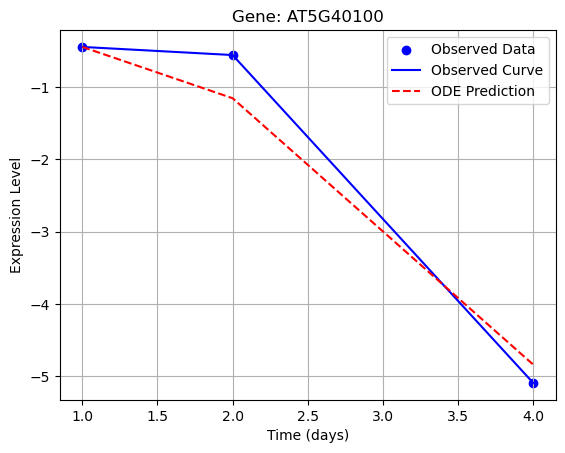

Learned ODE for Gene AT5G40100:
  dy/dt = -0.0029 + 0.3645 * y + -0.2869 * t
Formatted ODE Equation: dy/dt = -0.0029 + 0.3645 * y(t) + -0.2869 * t



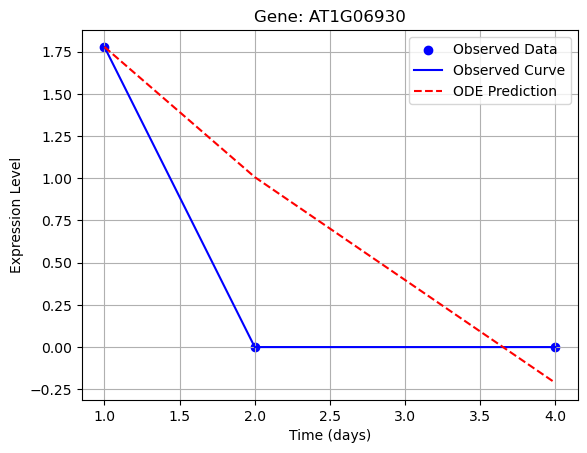

Learned ODE for Gene AT1G06930:
  dy/dt = -0.2061 + -0.3035 * y + -0.0973 * t
Formatted ODE Equation: dy/dt = -0.2061 + -0.3035 * y(t) + -0.0973 * t



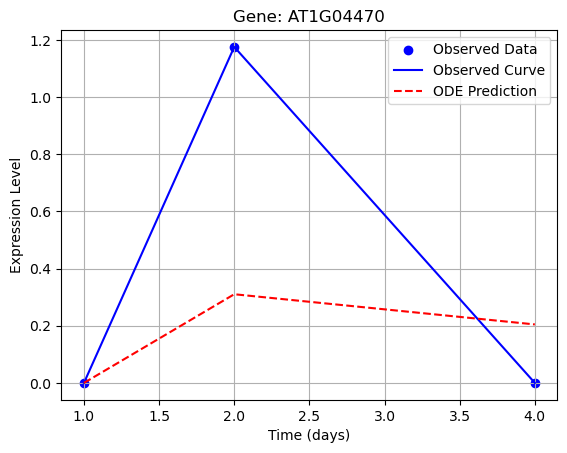

Learned ODE for Gene AT1G04470:
  dy/dt = 0.6920 + -0.4017 * y + -0.2056 * t
Formatted ODE Equation: dy/dt = 0.6920 + -0.4017 * y(t) + -0.2056 * t



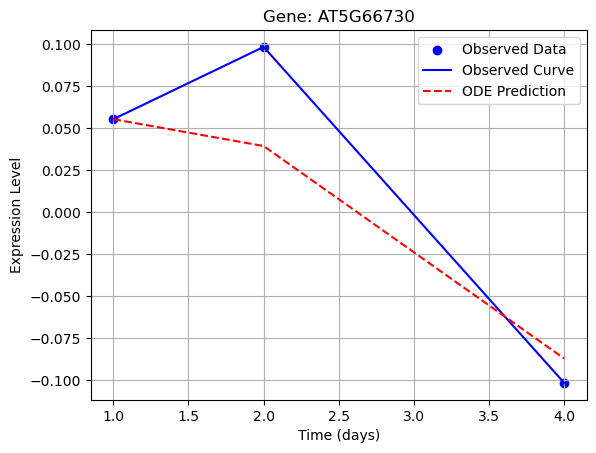

Learned ODE for Gene AT5G66730:
  dy/dt = 0.0370 + -0.0493 * y + -0.0337 * t
Formatted ODE Equation: dy/dt = 0.0370 + -0.0493 * y(t) + -0.0337 * t



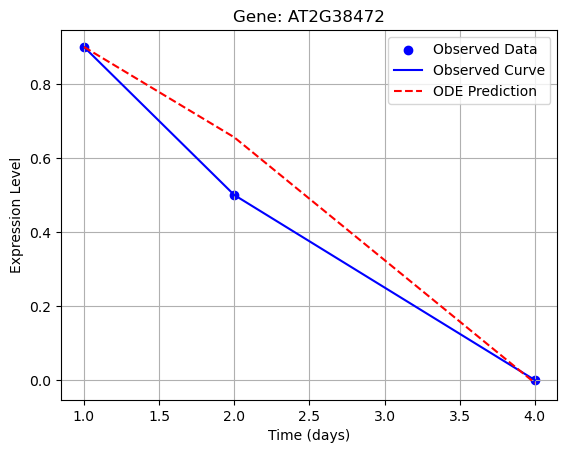

Learned ODE for Gene AT2G38472:
  dy/dt = -0.0478 + -0.0889 * y + -0.0845 * t
Formatted ODE Equation: dy/dt = -0.0478 + -0.0889 * y(t) + -0.0845 * t



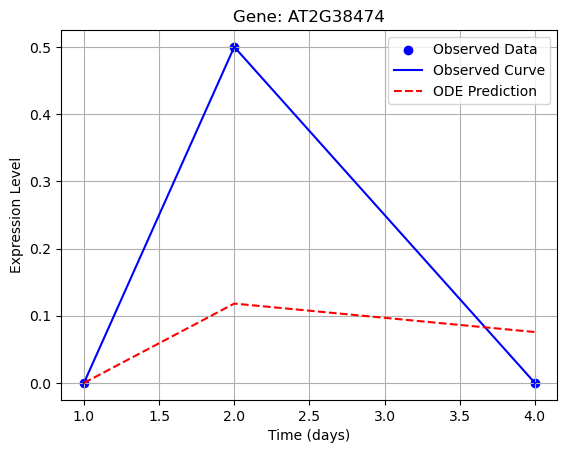

Learned ODE for Gene AT2G38474:
  dy/dt = 0.2588 + -0.1420 * y + -0.0874 * t
Formatted ODE Equation: dy/dt = 0.2588 + -0.1420 * y(t) + -0.0874 * t



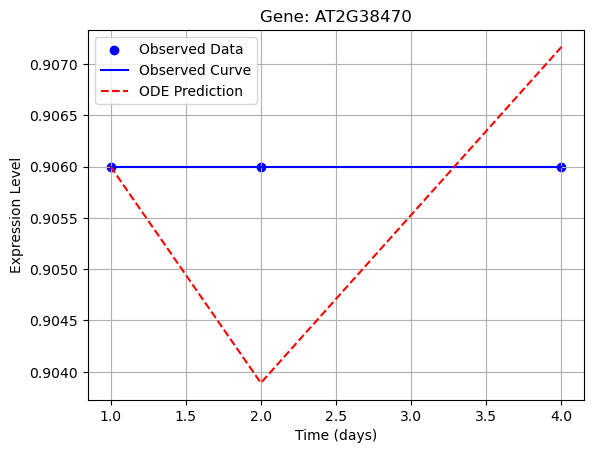

Learned ODE for Gene AT2G38470:
  dy/dt = 0.0086 + -0.0159 * y + 0.0025 * t
Formatted ODE Equation: dy/dt = 0.0086 + -0.0159 * y(t) + 0.0025 * t


Learned Parameters:
        Gene     alpha      beta     gamma
0  AT5G40100 -0.002922  0.364459 -0.286876
1  AT1G06930 -0.206085 -0.303508 -0.097298
2  AT1G04470  0.691965 -0.401743 -0.205646
3  AT5G66730  0.036963 -0.049306 -0.033653
4  AT2G38472 -0.047785 -0.088944 -0.084508
5  AT2G38474  0.258802 -0.141963 -0.087414
6  AT2G38470  0.008567 -0.015940  0.002497

Parameters with Individual Clusters:
        Gene     alpha      beta     gamma  alpha_cluster  beta_cluster  \
0  AT5G40100 -0.002922  0.364459 -0.286876              1             2   
1  AT1G06930 -0.206085 -0.303508 -0.097298              2             0   
2  AT1G04470  0.691965 -0.401743 -0.205646              0             0   
3  AT5G66730  0.036963 -0.049306 -0.033653              1             1   
4  AT2G38472 -0.047785 -0.088944 -0.084508              1             1   
5

c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


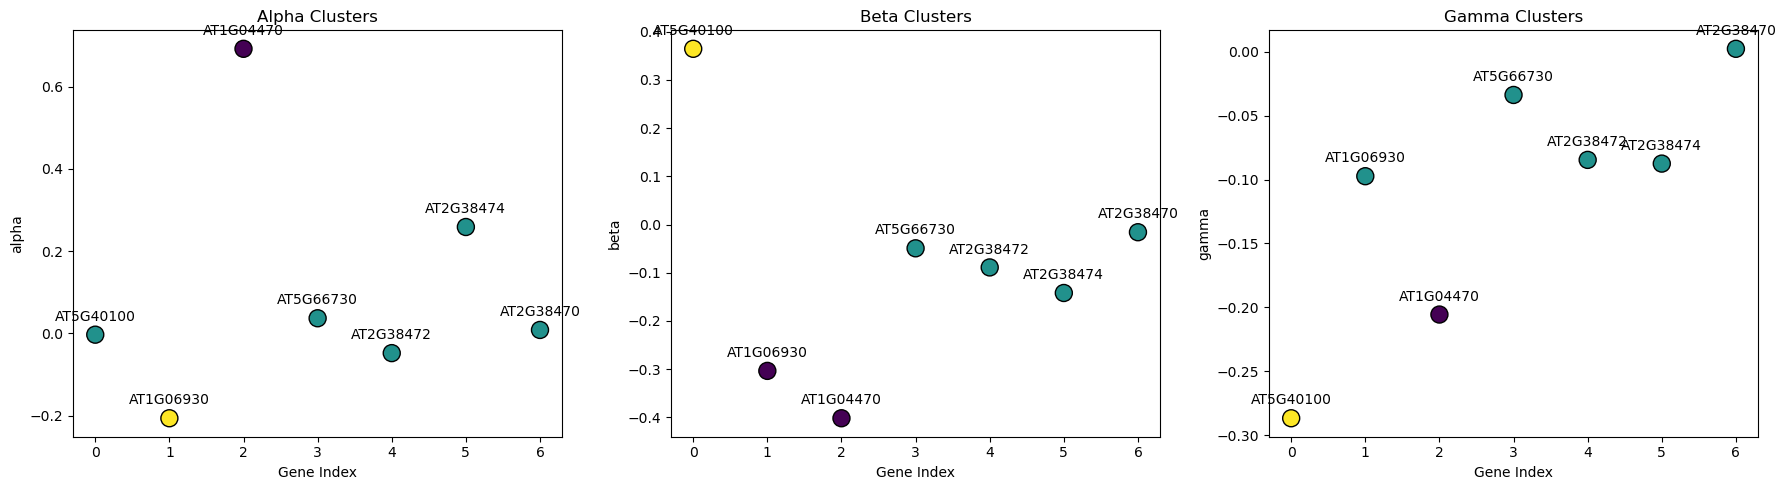


Cluster Analysis for Alpha:
Alpha Cluster 0: AT1G04470
Alpha Cluster 1: AT5G40100, AT5G66730, AT2G38472, AT2G38474, AT2G38470
Alpha Cluster 2: AT1G06930

Cluster Analysis for Beta:
Beta Cluster 0: AT1G06930, AT1G04470
Beta Cluster 1: AT5G66730, AT2G38472, AT2G38474, AT2G38470
Beta Cluster 2: AT5G40100

Cluster Analysis for Gamma:
Gamma Cluster 0: AT1G04470
Gamma Cluster 1: AT1G06930, AT5G66730, AT2G38472, AT2G38474, AT2G38470
Gamma Cluster 2: AT5G40100


In [104]:
##############################################################################
# Plotting Predictions and Printing Learned ODE Parameters
##############################################################################

with torch.no_grad():
    for i, gene_id in enumerate(df['Unnamed: 0']):
        # Use the Day1 value as the initial condition for each gene
        y0 = gene_data_tensor[i, 0].unsqueeze(0)  # shape: (1,)
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()

        # Plot observed data vs. ODE predictions
        plt.figure()
        plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
        plt.plot(time_points, gene_data[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="ODE Prediction")
        plt.title(f"Gene: {gene_id}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Print learned parameters for the gene
        model = ode_models[i]
        alpha = model.alpha.item()
        beta = model.beta.item()
        gamma = model.gamma.item()
        print(f"Learned ODE for Gene {gene_id}:")
        print(f"  dy/dt = {alpha:.4f} + {beta:.4f} * y + {gamma:.4f} * t")
        print(f"Formatted ODE Equation: dy/dt = {alpha:.4f} + {beta:.4f} * y(t) + {gamma:.4f} * t\n")

##############################################################################
# Clustering Learned Parameters Separately for alpha, beta, and gamma
##############################################################################

# Create a DataFrame to store parameters
params_df = pd.DataFrame(columns=['Gene', 'alpha', 'beta', 'gamma'])

with torch.no_grad():
    for i, gene_id in enumerate(df['Unnamed: 0']):
        model = ode_models[i]
        params_df.loc[i] = [
            gene_id,
            model.alpha.item(),
            model.beta.item(),
            model.gamma.item()
        ]

print("\nLearned Parameters:")
print(params_df)

# Cluster each parameter individually
from sklearn.cluster import KMeans

# Cluster for alpha
alphas = params_df['alpha'].values.reshape(-1, 1)
kmeans_alpha = KMeans(n_clusters=3, random_state=42).fit(alphas)
params_df['alpha_cluster'] = kmeans_alpha.labels_

# Cluster for beta
betas = params_df['beta'].values.reshape(-1, 1)
kmeans_beta = KMeans(n_clusters=3, random_state=42).fit(betas)
params_df['beta_cluster'] = kmeans_beta.labels_

# Cluster for gamma
gammas = params_df['gamma'].values.reshape(-1, 1)
kmeans_gamma = KMeans(n_clusters=3, random_state=42).fit(gammas)
params_df['gamma_cluster'] = kmeans_gamma.labels_

print("\nParameters with Individual Clusters:")
print(params_df)

##############################################################################
# Visualize Clusters for Each Parameter
##############################################################################

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# For alpha: simple scatter of gene index vs. alpha, colored by cluster
axs[0].scatter(range(len(alphas)), alphas, c=params_df['alpha_cluster'], cmap='viridis', s=150, edgecolor='k')
for i, txt in enumerate(params_df['Gene']):
    axs[0].annotate(txt, (i, alphas[i]), textcoords="offset points", xytext=(0,10), ha='center')
axs[0].set_title('Alpha Clusters')
axs[0].set_xlabel('Gene Index')
axs[0].set_ylabel('alpha')

# For beta
axs[1].scatter(range(len(betas)), betas, c=params_df['beta_cluster'], cmap='viridis', s=150, edgecolor='k')
for i, txt in enumerate(params_df['Gene']):
    axs[1].annotate(txt, (i, betas[i]), textcoords="offset points", xytext=(0,10), ha='center')
axs[1].set_title('Beta Clusters')
axs[1].set_xlabel('Gene Index')
axs[1].set_ylabel('beta')

# For gamma
axs[2].scatter(range(len(gammas)), gammas, c=params_df['gamma_cluster'], cmap='viridis', s=150, edgecolor='k')
for i, txt in enumerate(params_df['Gene']):
    axs[2].annotate(txt, (i, gammas[i]), textcoords="offset points", xytext=(0,10), ha='center')
axs[2].set_title('Gamma Clusters')
axs[2].set_xlabel('Gene Index')
axs[2].set_ylabel('gamma')

plt.tight_layout()
plt.show()

##############################################################################
# Cluster Analysis for Each Parameter
##############################################################################

print("\nCluster Analysis for Alpha:")
for cluster in sorted(params_df['alpha_cluster'].unique()):
    group = params_df[params_df['alpha_cluster'] == cluster]
    print(f"Alpha Cluster {cluster}: {', '.join(group['Gene'])}")

print("\nCluster Analysis for Beta:")
for cluster in sorted(params_df['beta_cluster'].unique()):
    group = params_df[params_df['beta_cluster'] == cluster]
    print(f"Beta Cluster {cluster}: {', '.join(group['Gene'])}")

print("\nCluster Analysis for Gamma:")
for cluster in sorted(params_df['gamma_cluster'].unique()):
    group = params_df[params_df['gamma_cluster'] == cluster]
    print(f"Gamma Cluster {cluster}: {', '.join(group['Gene'])}")


C:\Users\praba\AppData\Local\Temp\ipykernel_20244\2551134867.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='alpha_cluster', y='alpha', data=params_df, palette='viridis')


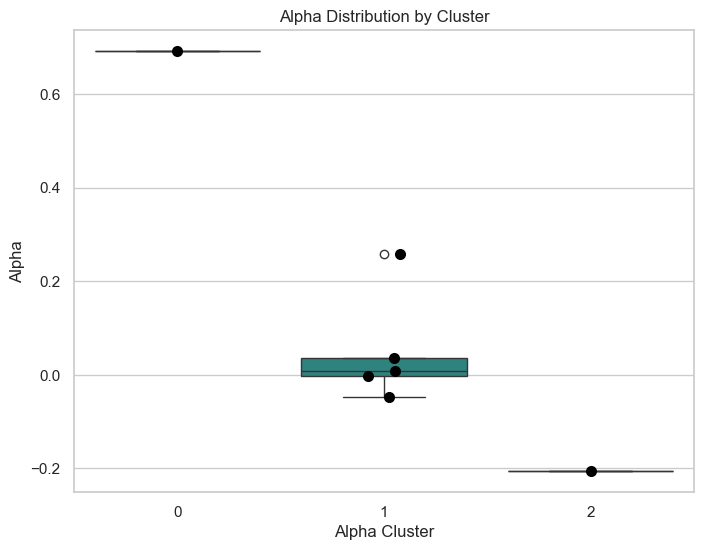

C:\Users\praba\AppData\Local\Temp\ipykernel_20244\2551134867.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='beta_cluster', y='beta', data=params_df, palette='viridis')


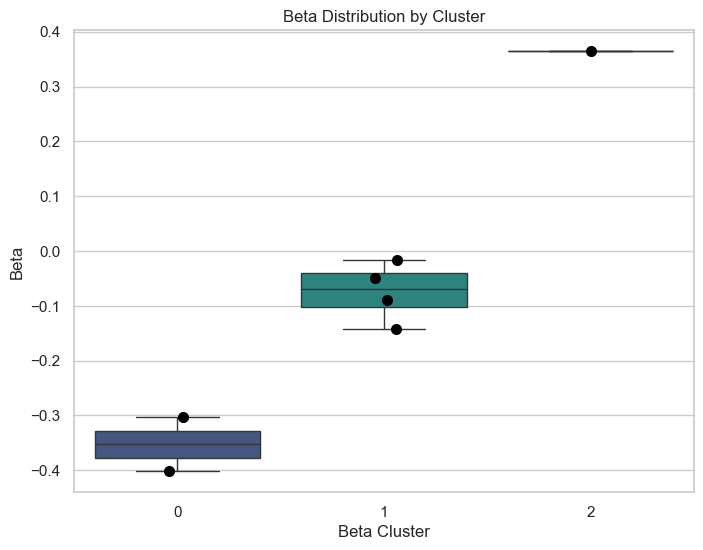

C:\Users\praba\AppData\Local\Temp\ipykernel_20244\2551134867.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gamma_cluster', y='gamma', data=params_df, palette='viridis')


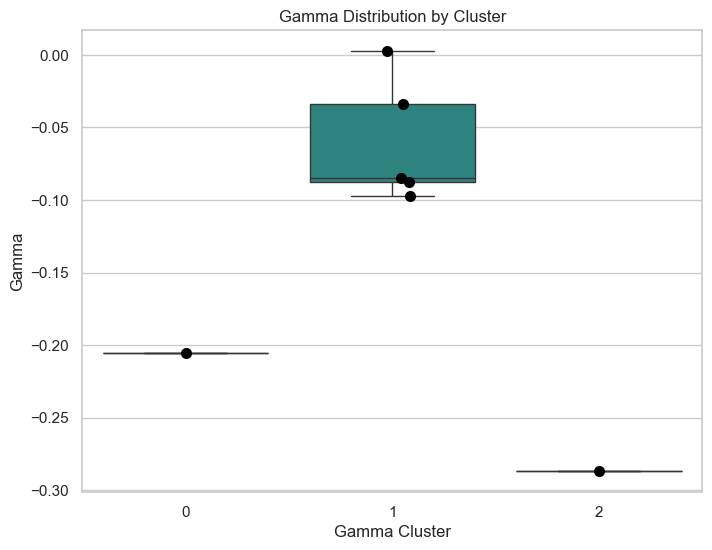

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Plot for alpha
plt.figure(figsize=(8, 6))
sns.boxplot(x='alpha_cluster', y='alpha', data=params_df, palette='viridis')
sns.stripplot(x='alpha_cluster', y='alpha', data=params_df, color='black', size=8, jitter=True)
plt.title('Alpha Distribution by Cluster')
plt.xlabel('Alpha Cluster')
plt.ylabel('Alpha')
plt.show()

# Plot for beta
plt.figure(figsize=(8, 6))
sns.boxplot(x='beta_cluster', y='beta', data=params_df, palette='viridis')
sns.stripplot(x='beta_cluster', y='beta', data=params_df, color='black', size=8, jitter=True)
plt.title('Beta Distribution by Cluster')
plt.xlabel('Beta Cluster')
plt.ylabel('Beta')
plt.show()

# Plot for gamma
plt.figure(figsize=(8, 6))
sns.boxplot(x='gamma_cluster', y='gamma', data=params_df, palette='viridis')
sns.stripplot(x='gamma_cluster', y='gamma', data=params_df, color='black', size=8, jitter=True)
plt.title('Gamma Distribution by Cluster')
plt.xlabel('Gamma Cluster')
plt.ylabel('Gamma')
plt.show()


C:\Users\praba\AppData\Local\Temp\ipykernel_20244\2577053300.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='alpha_cluster', y='alpha', data=params_df, palette='viridis', inner="quartile")


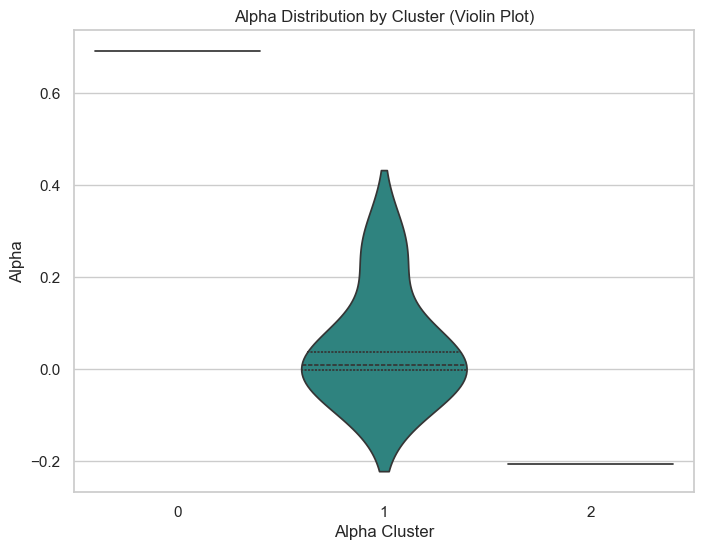

C:\Users\praba\AppData\Local\Temp\ipykernel_20244\2577053300.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='beta_cluster', y='beta', data=params_df, palette='viridis', inner="quartile")


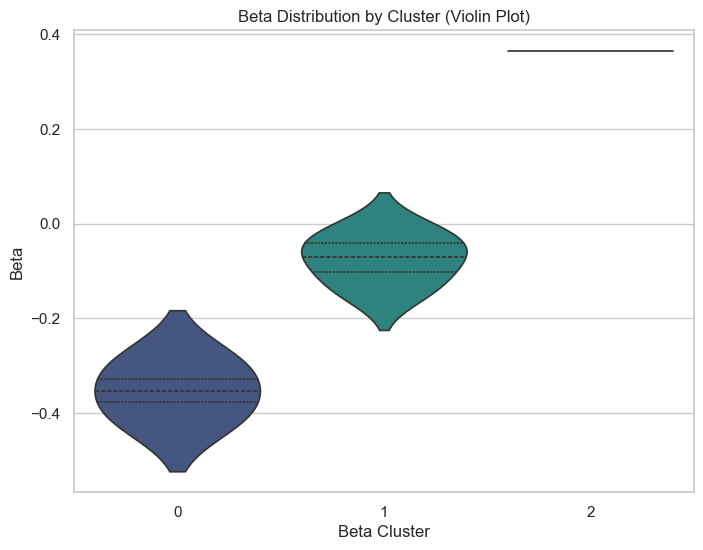

C:\Users\praba\AppData\Local\Temp\ipykernel_20244\2577053300.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='gamma_cluster', y='gamma', data=params_df, palette='viridis', inner="quartile")


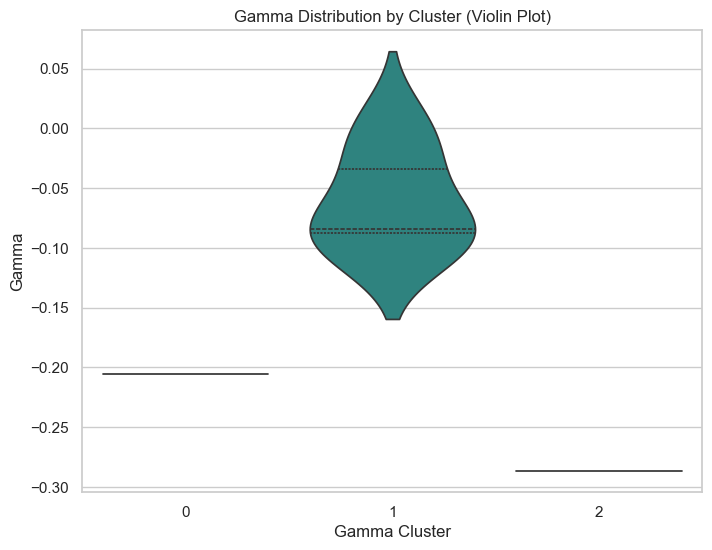

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Violin plot for alpha
plt.figure(figsize=(8, 6))
sns.violinplot(x='alpha_cluster', y='alpha', data=params_df, palette='viridis', inner="quartile")
plt.title('Alpha Distribution by Cluster (Violin Plot)')
plt.xlabel('Alpha Cluster')
plt.ylabel('Alpha')
plt.show()

# Violin plot for beta
plt.figure(figsize=(8, 6))
sns.violinplot(x='beta_cluster', y='beta', data=params_df, palette='viridis', inner="quartile")
plt.title('Beta Distribution by Cluster (Violin Plot)')
plt.xlabel('Beta Cluster')
plt.ylabel('Beta')
plt.show()

# Violin plot for gamma
plt.figure(figsize=(8, 6))
sns.violinplot(x='gamma_cluster', y='gamma', data=params_df, palette='viridis', inner="quartile")
plt.title('Gamma Distribution by Cluster (Violin Plot)')
plt.xlabel('Gamma Cluster')
plt.ylabel('Gamma')
plt.show()


# 3

In [41]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# For clustering:
from sklearn.cluster import KMeans

##############################################################################
# 1. LOAD DATA
##############################################################################
# Adjust the path if needed, or replace with your dataframe-creation logic
df = pd.read_csv("arabido_example_genes.csv")

print("Original Data:")
print(df.head())

# Time points (in days: Day1, Day2, Day4)
time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)

# Extract gene expression data (each row is a gene, columns are expression at days 1,2,4)
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values
gene_ids = df["Unnamed: 0"].values  # e.g., gene names (AT5G40100, etc.)

# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)


Original Data:
  Unnamed: 0  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
0  AT5G40100  -0.447960  -0.560155  -5.091964
1  AT1G06930   1.778359   0.000000   0.000000
2  AT1G04470   0.000000   1.175150   0.000000
3  AT5G66730   0.055375   0.098435  -0.101757
4  AT2G38471   0.505000   0.505000   0.505000


In [42]:

##############################################################################
# 2. DEFINE NEURAL ODE MODEL + LOSS
##############################################################################
class GeneParametricODE(nn.Module):
    def __init__(self):
        super(GeneParametricODE, self).__init__()
        # Learnable ODE parameters: α, β, γ
        self.alpha = nn.Parameter(torch.tensor(0.1))
        self.beta  = nn.Parameter(torch.tensor(0.1))
        self.gamma = nn.Parameter(torch.tensor(0.1))

    def forward(self, t, y):
        # Parametric ODE: dy/dt = α + β*y + γ*t
        return self.alpha + self.beta * y + self.gamma * t

# Create one model per gene
num_genes = gene_data_tensor.shape[0]
ode_models = nn.ModuleList([GeneParametricODE() for _ in range(num_genes)])

def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
    total_data_loss = 0.0
    total_physics_loss = 0.0
    n_genes = gene_data.shape[0]

    for i in range(n_genes):
        y_observed = gene_data[i]               # shape: [3 time_points]
        y0 = y_observed[0].unsqueeze(0)         # initial condition from day1

        # Solve ODE through the specified time points
        preds = odeint(ode_models[i], y0, time_points).squeeze()

        # Data Loss (MSE between predictions and observations)
        data_loss = torch.mean((preds - y_observed)**2)

        # Physics Loss (ensure derivative matches the ODE definition)
        dy_dt_pred = torch.autograd.grad(
            outputs=preds,
            inputs=time_points,
            grad_outputs=torch.ones_like(preds),
            create_graph=True,
            retain_graph=True
        )[0]

        dy_dt_ode = []
        for t_val, p_val in zip(time_points, preds):
            deriv = ode_models[i](t_val, p_val.unsqueeze(0))
            dy_dt_ode.append(deriv.squeeze())
        dy_dt_ode = torch.stack(dy_dt_ode)

        physics_loss = torch.mean((dy_dt_pred - dy_dt_ode)**2)

        total_data_loss += data_loss
        total_physics_loss += physics_loss

    avg_data_loss = total_data_loss / n_genes
    avg_physics_loss = total_physics_loss / n_genes
    total_loss = avg_data_loss + lambda_physics * avg_physics_loss
    return total_loss, avg_data_loss, avg_physics_loss


In [43]:

##############################################################################
# 3. TRAINING
##############################################################################
optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, data_loss, physics_loss = inverse_pinn_loss(
        ode_models,
        time_points_tensor,
        gene_data_tensor,
        lambda_physics=0.1
    )
    total_loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | "
              f"Total Loss: {total_loss.item():.4f} | "
              f"Data Loss: {data_loss.item():.4f} | "
              f"Physics Loss: {physics_loss.item():.4f}")

Epoch    0 | Total Loss: 2.5838 | Data Loss: 2.5576 | Physics Loss: 0.2623
Epoch  100 | Total Loss: 0.1578 | Data Loss: 0.1165 | Physics Loss: 0.4130
Epoch  200 | Total Loss: 0.1452 | Data Loss: 0.1044 | Physics Loss: 0.4079
Epoch  300 | Total Loss: 0.1385 | Data Loss: 0.0982 | Physics Loss: 0.4030
Epoch  400 | Total Loss: 0.1348 | Data Loss: 0.0947 | Physics Loss: 0.4004
Epoch  500 | Total Loss: 0.1328 | Data Loss: 0.0929 | Physics Loss: 0.3990
Epoch  600 | Total Loss: 0.1317 | Data Loss: 0.0919 | Physics Loss: 0.3982
Epoch  700 | Total Loss: 0.1311 | Data Loss: 0.0913 | Physics Loss: 0.3977
Epoch  800 | Total Loss: 0.1308 | Data Loss: 0.0911 | Physics Loss: 0.3975
Epoch  900 | Total Loss: 0.1306 | Data Loss: 0.0909 | Physics Loss: 0.3973


In [37]:


##############################################################################
# 4. EXTRACT LEARNED PARAMETERS & CLUSTER
##############################################################################
# Collect alpha, beta, gamma for each gene
params_list = []
for i, model in enumerate(ode_models):
    alpha = model.alpha.item()
    beta = model.beta.item()
    gamma = model.gamma.item()
    params_list.append([alpha, beta, gamma])

params_array = np.array(params_list)  # shape: [num_genes, 3]

# Let's do a simple K-Means with 2 clusters (you can adjust n_clusters)
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(params_array)
cluster_labels = kmeans.labels_

# Print out cluster assignments
print("Cluster assignments for each gene:")
for gene, label in zip(gene_ids, cluster_labels):
    print(f"Gene {gene} -> Cluster {label}")


Cluster assignments for each gene:
Gene AT5G40100 -> Cluster 0
Gene AT1G06930 -> Cluster 0
Gene AT1G04470 -> Cluster 1
Gene AT5G66730 -> Cluster 0
Gene AT2G38471 -> Cluster 0
Gene AT2G38472 -> Cluster 0
Gene AT2G38473 -> Cluster 0
Gene AT2G38474 -> Cluster 0
Gene AT2G38470 -> Cluster 0


c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


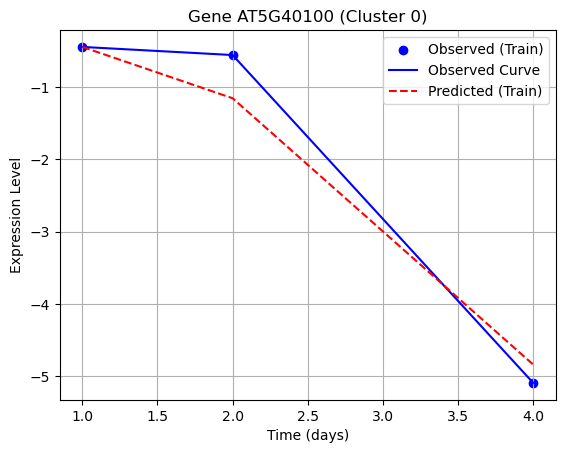

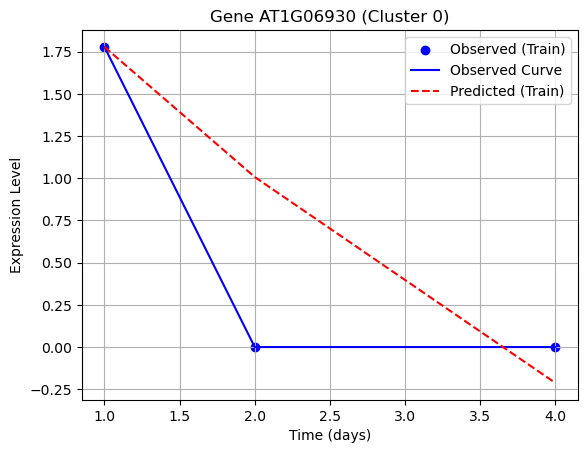

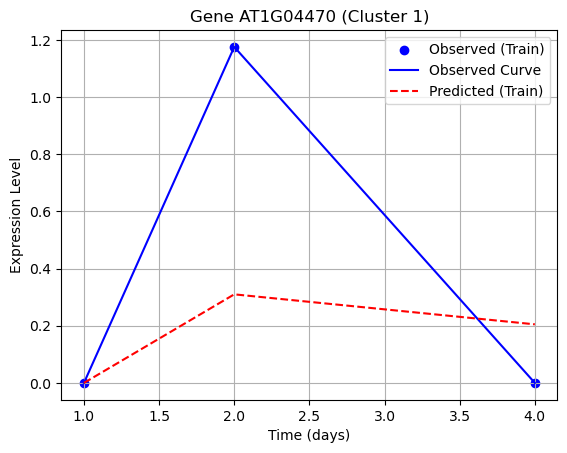

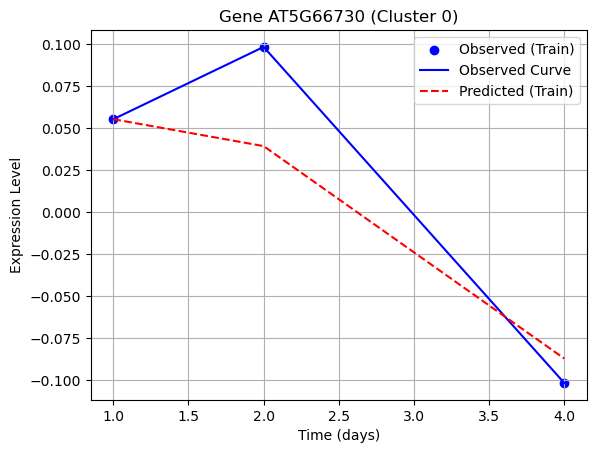

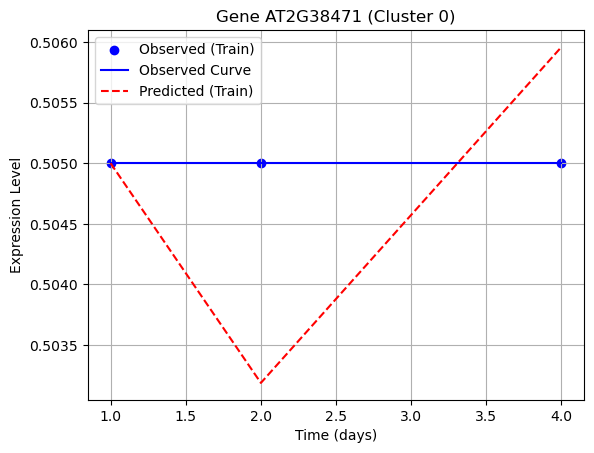

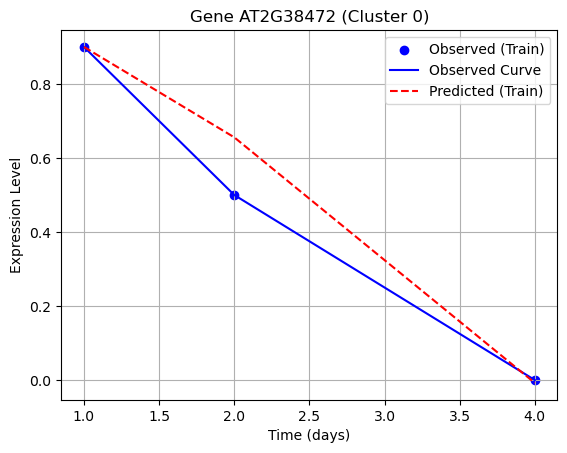

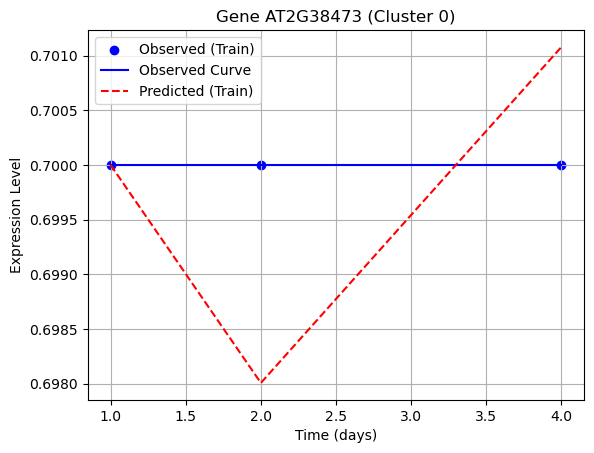

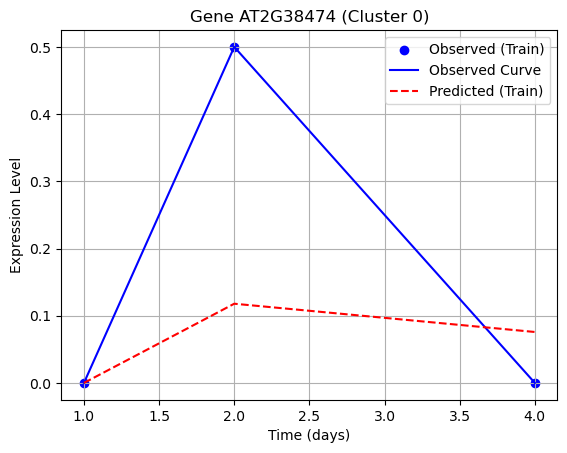

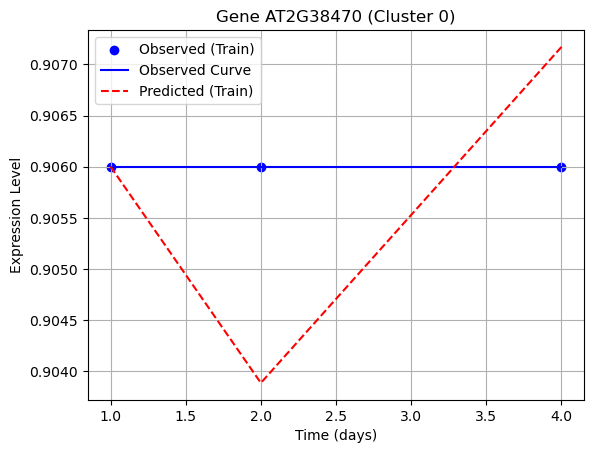

In [45]:

##############################################################################
# 5. APPLY MODEL: PREDICT & PLOT ON TRAIN DATA
##############################################################################
# (Optional) Plot the final predictions on the training data
with torch.no_grad():
    for i, gene_id in enumerate(gene_ids):
        y_observed = gene_data_tensor[i]
        y0 = y_observed[0].unsqueeze(0)
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()

        plt.figure()
        plt.scatter(time_points, y_observed, c='b', label="Observed (Train)")
        plt.plot(time_points, gene_data[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="Predicted (Train)")
        plt.title(f"Gene {gene_id} (Cluster {cluster_labels[i]})")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True)
        plt.show()

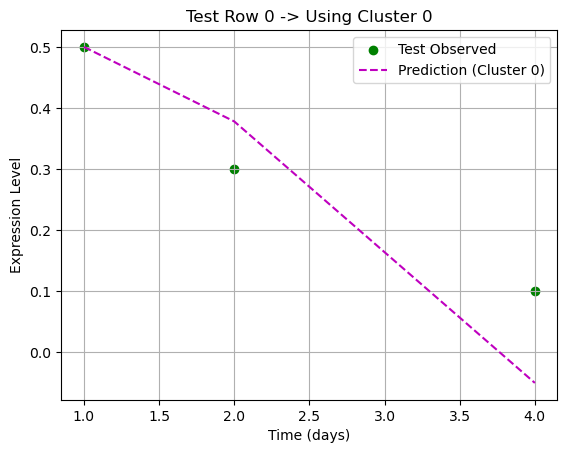

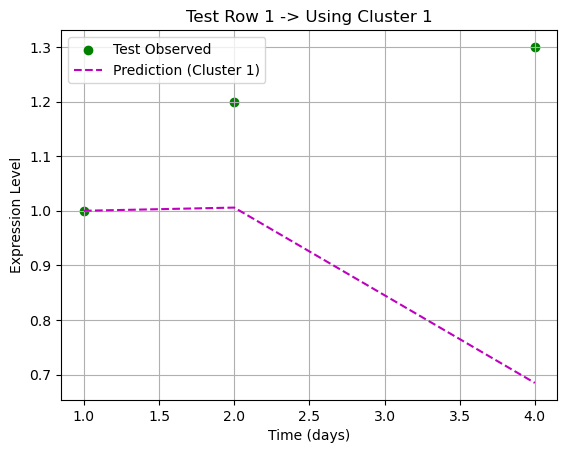

In [39]:


##############################################################################
# 6. CREATE A SMALL TEST DATASET AND PREDICT USING CLUSTER AVERAGE
##############################################################################
# This is a simple synthetic example. Each row is: [Day1, Day2, Day4].
# Suppose we have 2 new "genes" that we suspect belong to cluster 0 or 1.
test_data = np.array([
    [0.5, 0.3, 0.1],  # Potentially cluster 0
    [1.0, 1.2, 1.3],  # Potentially cluster 1
], dtype=np.float32)

# Compute the cluster centers so we have average [alpha, beta, gamma]
cluster_centers = kmeans.cluster_centers_  # shape [n_clusters, 3]

def predict_with_cluster_center(cluster_id, time_points, y0):
    """Predict using the mean alpha,beta,gamma of the given cluster."""
    alpha_c, beta_c, gamma_c = cluster_centers[cluster_id]
    # Build a quick parametric ODE with these cluster-based parameters
    class ClusterODE(nn.Module):
        def forward(_self, t, y):
            return alpha_c + beta_c * y + gamma_c * t

    cluster_model = ClusterODE()
    preds = odeint(cluster_model, y0, time_points).squeeze().numpy()
    return preds

# For each test example, we guess its cluster by minimizing distance to cluster center
with torch.no_grad():
    for idx, row in enumerate(test_data):
        # Row is [Day1, Day2, Day4], we use Day1 as initial condition
        y0 = torch.tensor([row[0]], dtype=torch.float32, requires_grad=False)
        
        # We pick the cluster by comparing the expression pattern or simply picking a cluster
        # For demonstration, let's do a naive approach: 
        # choose cluster 0 if row[0] < 0.7 else cluster 1, etc. 
        # You could do something more sophisticated if you like.
        guess_cluster = 0 if row[0] < 0.7 else 1
        
        preds = predict_with_cluster_center(guess_cluster, time_points_tensor, y0)
        
        # Plot test data vs. cluster-based ODE prediction
        plt.figure()
        plt.scatter(time_points, row, c='g', label="Test Observed")
        plt.plot(time_points, preds, 'm--', label=f"Prediction (Cluster {guess_cluster})")
        plt.title(f"Test Row {idx} -> Using Cluster {guess_cluster}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True)
        plt.show()


In [40]:

##############################################################################
# 7. PRINT THE FINAL PARAMETERS (α, β, γ) FOR REFERENCE
##############################################################################
print("\nLearned parameters (alpha, beta, gamma) per gene:")
for gene_id, (alpha, beta, gamma) in zip(gene_ids, params_array):
    print(f"Gene: {gene_id}")
    print(f"  α={alpha:.4f}, β={beta:.4f}, γ={gamma:.4f}")


Learned parameters (alpha, beta, gamma) per gene:
Gene: AT5G40100
  α=-0.0845, β=0.3652, γ=-0.2475
Gene: AT1G06930
  α=-0.1884, β=-0.2347, γ=-0.1223
Gene: AT1G04470
  α=0.4673, β=-0.2561, γ=-0.1344
Gene: AT5G66730
  α=0.0189, β=-0.0562, γ=-0.0260
Gene: AT2G38471
  α=0.0059, β=-0.0259, γ=0.0030
Gene: AT2G38472
  α=-0.0591, β=-0.0863, γ=-0.0803
Gene: AT2G38473
  α=0.0066, β=-0.0207, γ=0.0034
Gene: AT2G38474
  α=0.1733, β=-0.0939, γ=-0.0544
Gene: AT2G38470
  α=0.0069, β=-0.0171, γ=0.0036


# 2. On new data set

In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# filepath: c:\Users\praba\Documents\GitHub\research-project-on-physics-informed-machine-learning-on-transcriptomics-data\some extra papers\examples.csv
# PLEASE ensure the path is correct if you run locally:
df = pd.read_csv(r"c:\Users\praba\Documents\GitHub\research-project-on-physics-informed-machine-learning-on-transcriptomics-data\some extra papers\examples.csv", sep=';')

print("Original Data:")
print(df.head())


Original Data:
                   gene_id  Bc_0h_r1  Bc_0h_r2  Bc_0h_r3  Bc_16h_r1  \
0  mRNA:Solyc00g020040.1.1      1.83      1.26      1.97       2.20   
1  mRNA:Solyc00g500071.1.1     96.86     72.27     78.05      89.18   
2  mRNA:Solyc01g006900.3.1    115.08    139.10    140.02     228.40   
3  mRNA:Solyc01g008670.5.1      1.63      2.15      1.72      12.51   
4  mRNA:Solyc01g014105.1.1     47.85     36.69     46.12       1.94   

   Bc_16h_r2  Bc_16h_r3  Bc_23h_r1  Bc_23h_r2  Bc_23h_r3  Bc_40h_r1  \
0       2.76       3.04       3.31       1.65       3.51       7.71   
1      70.75      58.14      66.46      60.64      84.28      17.85   
2     314.11     308.32     293.75     355.25     320.53     407.63   
3      20.73       8.59      10.53      13.10       5.62      12.19   
4       1.92       2.79       4.73       5.28       7.43       1.15   

   Bc_40h_r2  Bc_40h_r3  Bc_47h_r1  Bc_47h_r2  Bc_47h_r3  
0       7.52       5.89       8.85       3.87       2.29  
1      31.76 

In [25]:

##############################################################################
# Data Setup
# Each gene has expression values measured at 0h, 16h, 23h, 40h, 47h for 3 replicates.
# We'll treat time points (in hours) as [0, 16, 23, 40, 47].
##############################################################################
time_points = np.array([0.0, 16.0, 23.0, 40.0, 47.0], dtype=np.float32)

# For convenience, define replicate column sets:
replicate_columns_r1 = ["Bc_0h_r1", "Bc_16h_r1", "Bc_23h_r1", "Bc_40h_r1", "Bc_47h_r1"]
replicate_columns_r2 = ["Bc_0h_r2", "Bc_16h_r2", "Bc_23h_r2", "Bc_40h_r2", "Bc_47h_r2"]
replicate_columns_r3 = ["Bc_0h_r3", "Bc_16h_r3", "Bc_23h_r3", "Bc_40h_r3", "Bc_47h_r3"]

# Extract expression data for each replicate, shape = [num_genes, 5]
r1_data = df[replicate_columns_r1].values
r2_data = df[replicate_columns_r2].values
r3_data = df[replicate_columns_r3].values

# Stack them to get shape = [num_genes, 3 replicates, 5 time_points]
# So gene_data[i, 0, :] = replicate1 for gene i, gene_data[i, 1, :] = replicate2, etc.
gene_data = np.stack([r1_data, r2_data, r3_data], axis=1)

# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)
# shape = [num_genes, 3, 5]
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

# Number of genes
num_genes = gene_data_tensor.shape[0]
print("Gene data shape (num_genes, replicates, time_points):", gene_data_tensor.shape)

Gene data shape (num_genes, replicates, time_points): torch.Size([6, 3, 5])


In [27]:


##############################################################################
# Parametric ODE Model for Each Gene: dy/dt = α + β * y(t) + γ * t
##############################################################################
class GeneParametricODE(nn.Module):
    def __init__(self):
        super(GeneParametricODE, self).__init__()
        # Learnable parameters for each gene
        self.alpha = nn.Parameter(torch.tensor(0.1))
        self.beta = nn.Parameter(torch.tensor(0.1))
        self.gamma = nn.Parameter(torch.tensor(0.1))

    def forward(self, t, y):
        # ODE: dy/dt = α + β * y + γ * t
        return self.alpha + self.beta * y + self.gamma * t

# Create one ODE model per gene
ode_models = nn.ModuleList([GeneParametricODE() for _ in range(num_genes)])

##############################################################################
# Inverse PINN Loss Function (Data Loss + Physics Loss)
##############################################################################
def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
    """
    gene_data: shape [num_genes, 3 replicates, 5 time_points]
    time_points:  shape [5]
    """
    total_data_loss = 0.0
    total_physics_loss = 0.0
    n_genes = gene_data.shape[0]
    n_replicates = gene_data.shape[1]  # 3

    for i in range(n_genes):
        # We'll sum losses across replicates
        data_loss_gene = 0.0
        physics_loss_gene = 0.0

        for r in range(n_replicates):
            y_observed = gene_data[i, r, :]  # shape [5]
            # Use the 0h value (index 0) as the initial condition
            y0 = y_observed[0].unsqueeze(0)  # shape [1]

            # Solve the ODE for gene i over the time points
            preds = odeint(ode_models[i], y0, time_points).squeeze()  # shape [5]

            # Data loss: Mean squared error between predictions and observed
            data_loss_rep = torch.mean((preds - y_observed)**2)

            # Physics loss: derivative from autograd vs. ODE definition
            dy_dt_pred = torch.autograd.grad(
                outputs=preds,
                inputs=time_points,
                grad_outputs=torch.ones_like(preds),
                create_graph=True,
                retain_graph=True
            )[0]

            # Evaluate ODE at each time point
            dy_dt_ode = []
            for t_val, p_val in zip(time_points, preds):
                deriv = ode_models[i](t_val, p_val.unsqueeze(0))
                dy_dt_ode.append(deriv.squeeze())
            dy_dt_ode = torch.stack(dy_dt_ode)

            physics_loss_rep = torch.mean((dy_dt_pred - dy_dt_ode)**2)

            data_loss_gene += data_loss_rep
            physics_loss_gene += physics_loss_rep

        # Average across replicates for this gene
        data_loss_gene /= n_replicates
        physics_loss_gene /= n_replicates

        total_data_loss += data_loss_gene
        total_physics_loss += physics_loss_gene

    # Average across all genes
    avg_data_loss = total_data_loss / n_genes
    avg_physics_loss = total_physics_loss / n_genes
    total_loss = avg_data_loss + lambda_physics * avg_physics_loss
    return total_loss, avg_data_loss, avg_physics_loss


In [28]:

##############################################################################
# Training Loop
##############################################################################
optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
epochs = 10000

for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, data_loss, physics_loss = inverse_pinn_loss(
        ode_models, 
        time_points_tensor, 
        gene_data_tensor, 
        lambda_physics=0.1
    )
    total_loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Total Loss: {total_loss.item():.4f} "
              f"| Data Loss: {data_loss.item():.4f} "
              f"| Physics Loss: {physics_loss.item():.4f}")


Epoch    0 | Total Loss: 22364072.0000 | Data Loss: 22334062.0000 | Physics Loss: 300102.5938
Epoch  100 | Total Loss: 2665753.2500 | Data Loss: 2663043.5000 | Physics Loss: 27096.9004
Epoch  200 | Total Loss: 2512743.5000 | Data Loss: 2510870.7500 | Physics Loss: 18726.8809
Epoch  300 | Total Loss: 2453878.2500 | Data Loss: 2452298.7500 | Physics Loss: 15795.4893
Epoch  400 | Total Loss: 2425823.2500 | Data Loss: 2424374.7500 | Physics Loss: 14484.6318
Epoch  500 | Total Loss: 2411454.5000 | Data Loss: 2410070.7500 | Physics Loss: 13837.5830
Epoch  600 | Total Loss: 2403886.5000 | Data Loss: 2402536.2500 | Physics Loss: 13502.6914
Epoch  700 | Total Loss: 2399862.0000 | Data Loss: 2398529.2500 | Physics Loss: 13326.3359
Epoch  800 | Total Loss: 2397719.0000 | Data Loss: 2396395.7500 | Physics Loss: 13233.2334
Epoch  900 | Total Loss: 2396579.2500 | Data Loss: 2395261.0000 | Physics Loss: 13183.4521
Epoch 1000 | Total Loss: 2395976.7500 | Data Loss: 2394661.0000 | Physics Loss: 13157.0

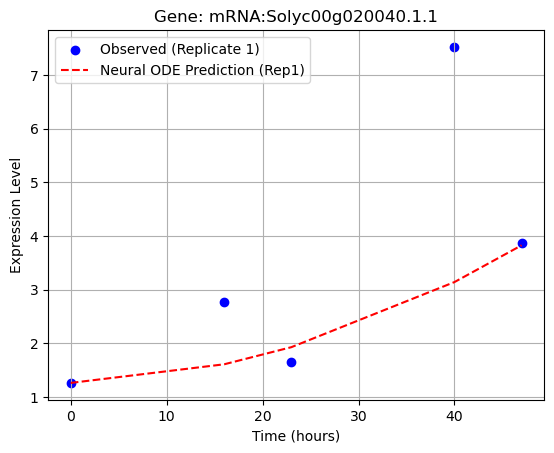

Learned ODE for Gene mRNA:Solyc00g020040.1.1:
  dy/dt = 0.0021 + 0.0027 * y + 0.0020 * t



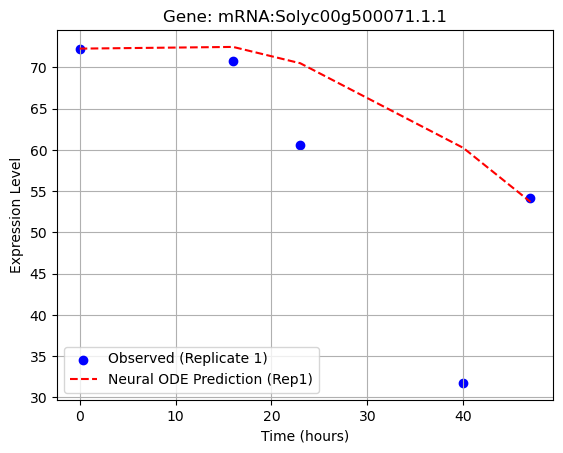

Learned ODE for Gene mRNA:Solyc00g500071.1.1:
  dy/dt = -0.0104 + 0.0031 * y + -0.0253 * t



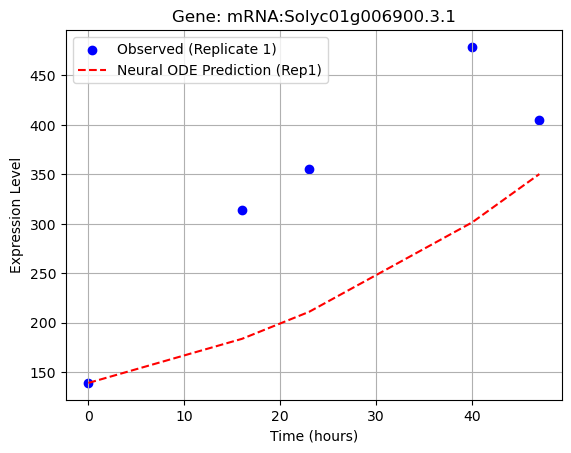

Learned ODE for Gene mRNA:Solyc01g006900.3.1:
  dy/dt = 0.0296 + 0.0148 * y + 0.0488 * t



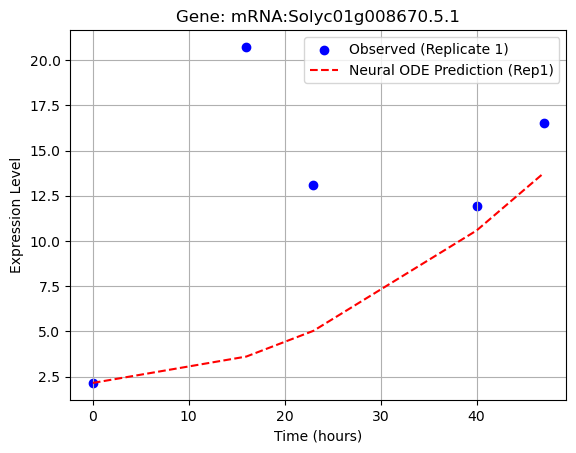

Learned ODE for Gene mRNA:Solyc01g008670.5.1:
  dy/dt = 0.0075 + 0.0036 * y + 0.0093 * t



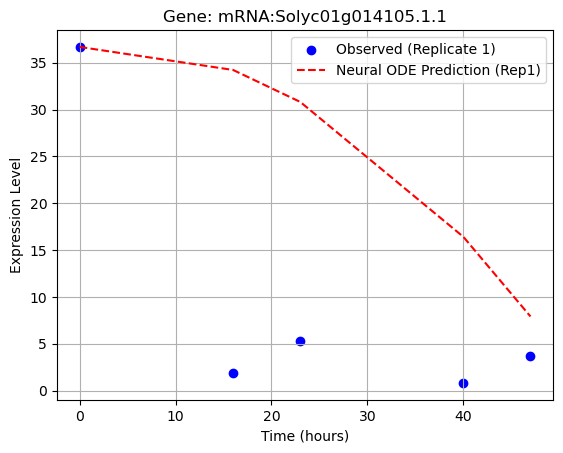

Learned ODE for Gene mRNA:Solyc01g014105.1.1:
  dy/dt = -0.0135 + 0.0024 * y + -0.0283 * t



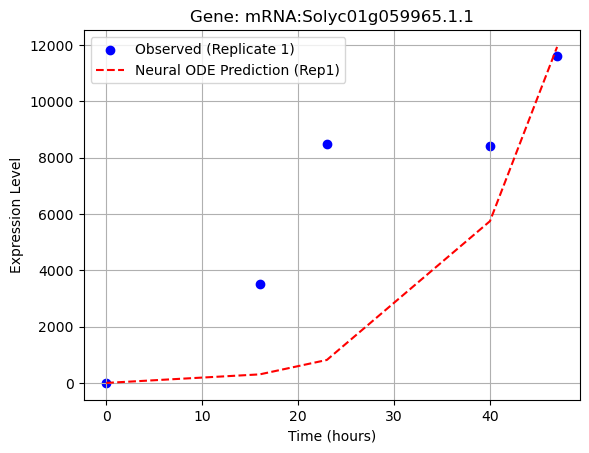

Learned ODE for Gene mRNA:Solyc01g059965.1.1:
  dy/dt = 1.0207 + 0.0990 * y + 0.9837 * t



In [23]:

##############################################################################
# Plotting Predictions and Printing Learned ODE Parameters
##############################################################################
with torch.no_grad():
    gene_ids = df['gene_id'].values  # from CSV
    for i, gene_id in enumerate(gene_ids):
        # We'll just plot replicate 1 for demonstration
        # (You can adapt to plot all replicates as needed)
        y_observed = gene_data_tensor[i, 1, :]  # shape [5]
        y0 = y_observed[0].unsqueeze(0)
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()

        plt.figure()
        plt.scatter(time_points, y_observed, c='b', label="Observed (Replicate 1)")
        plt.plot(time_points, preds, 'r--', label="Neural ODE Prediction (Rep1)")
        plt.title(f"Gene: {gene_id}")
        plt.xlabel("Time (hours)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True)
        plt.show()

        model = ode_models[i]
        alpha, beta, gamma = model.alpha.item(), model.beta.item(), model.gamma.item()
        print(f"Learned ODE for Gene {gene_id}:")
        print(f"  dy/dt = {alpha:.4f} + {beta:.4f} * y + {gamma:.4f} * t")
        print()